# Surge Pricing in the Airbnb Market: Evidence from the 2017 Boston Marathon
### By: Eli Easton


# Project 1

# 1. Introduction

In April 2017, the Boston Marathon drew tens of thousands of people to Boston, Massachusetts (Boston Athletic Association, 2017). How, then, did this influx of visitors impact the Boston Airbnb market? Further, was there variation in 'marathon pricing behaviour' by host type?

Much research has been done on how ride sharing prices respond to events (Jiao, 2018; Cachon et al., 2017). There also exists literature on how events impact hotel performance (Piga & Melis, 2021). However, there exists far less literature on Airbnb's dynamic pricing behaviour (Leoni & Nilsson, 2021). 

In Project 1, I use the Boston Airbnb Calendar and Listings datasets, alongside a Crime in Boston dataset, which were all sourced from Kaggle, to conduct my analysis. I first find that Airbnb listing prices spiked the weekend before and the day of the Boston Marathon. 
From this, I hypothesize that the Boston Marathon increased local demand only for Airbnbs near the boston marathon route, and that Airbnbs farther from the route are not impacted by this hypothesized demand surge brought about by the marathon. This hypothesis is crucial because if it holds I can assign listings into treatment and control groups. I find that it indeed holds after comparing price distributions for listings 'close', 'mid-range', and 'far' from the marathon finish line. 

Then, in Project 2, I provide 4 maps and conduct both a two-period and panel difference-in-differences regression analyses akin to Angrist & Pischke (2015). I test my regression assumptions by conducting a parallel trends assessment as described by Fredriksson & Oliveira (2019). I also perform placebo tests for both regression analyses as outlined by Cunningham (2021). I ultimately find that there was a ‘Boston Marathon effect’ on Airbnb listing prices for listings 'close' to the finish line, and that Superhosts vary in their 'marathon pricing strategy' compared to non Superhosts.



# 2. Data Cleaning & Loading

I begin with the Boston Airbnb Calendar dataset, which contains 1.05 million observations of Airbnb listing-dates in Boston from September 2016 to September 2017. This dataset allows me to observe the change in a property's listing price over time. To obtain more detailed information on Airbnb properties, I then merge it with the Boston Airbnb Listings dataset, which contains data on the characteristics of these 3586 Airbnb properties. Lastly, it is understood that the level of crime in a neighbourhood impacts property value (Cheung & Yiu, 2023). Therefore, I also merge the Crimes in Boston dataset to control for daily fluctuations in crime.

My main outcome variable is daily Airbnb listing prices. My main controls are room, property, and bed type, the number of bathrooms, bedrooms, and beds. Intuitively, these variables influince price. However, I also consider controlling for review score rating and a Superhost dummy. Akin to Lawani et al. (2019) review scores can serve as a proxy for property quality, which influences price. Also, Superhost status is another indicator of quality that may impact pricing (Ert & Fleischer, 2019).

In [1898]:
#! pip install -q matplotlib numpy pandas qeds seaborn

In [1899]:
#Import libraries
import matplotlib
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as dates
import numpy as np
import pandas as pd
from pandas_datareader import DataReader
import qeds
import seaborn as sns
import statsmodels.api as sm
import stargazer as Stargazer
from stargazer.stargazer import Stargazer
from IPython.display import display, HTML
import geopandas as gpd
import geodatasets
from shapely.geometry import Point

#Change font to Garamond
plt.rcParams["font.family"] = "Garamond"

#Load calendar dataset
calendar = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                       "ECO225Project\\Data\\Boston\\calendar.csv")

#Clean "calendar"

#Rename "listing_id" column to "id"
calendar.rename(columns={"listing_id": "id"}, inplace=True)

#Clean price column to remove $ and zeroes, convert to float
calendar["price"] = calendar["price"].astype(str).str.replace("$", 
                    "").str.replace(".00", "").str.replace(",", "") \
                    .astype(float)

#Create "year_month" column from the "date" column in "df_calendar" dataset
#Convert "date" column to datetime
#Documentation: 
#https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
calendar["date"] = pd.to_datetime(calendar["date"])

#Create "year_month" column
calendar["year_month"] = calendar["date"].dt.to_period("M")

#Set calendar index
calendar.set_index("id")

#Load listings dataset
listings = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                    "ECO225Project\\Data\\Boston\\listings.csv").set_index("id")

#Clean "listings"

listings.drop(columns=["listing_url", "scrape_id", "last_scraped", "name", 
                       "summary", "space", "description", 
                       "experiences_offered", "neighborhood_overview", 
                       "notes", "transit", "access", "interaction", 
                       "house_rules", "thumbnail_url", "medium_url", 
                       "picture_url", "xl_picture_url", "host_id", 
                       "host_url", "host_name", "host_since", "host_location", 
                       "host_about", "host_response_time", 
                       "host_response_rate", "host_acceptance_rate", 
                       "host_thumbnail_url", "host_picture_url", 
                       "host_neighbourhood", "host_listings_count", 
                       "host_verifications", "host_has_profile_pic", 
                       "host_identity_verified", "neighbourhood", 
                       "neighbourhood_group_cleansed", "market", 
                       "smart_location", "country_code", "country", 
                       "is_location_exact", "weekly_price", "monthly_price", 
                       "calendar_updated", "has_availability", 
                       "availability_30", "availability_60", "availability_90", 
                       "availability_365", "calendar_last_scraped", 
                       "first_review", "last_review", 
                       "review_scores_accuracy", "review_scores_cleanliness", 
                       "review_scores_checkin", 
                       "review_scores_communication", "review_scores_location", 
                       "review_scores_value", "requires_license", 
                       "license", "jurisdiction_names", "instant_bookable", 
                       "cancellation_policy", "require_guest_profile_picture", 
                       "require_guest_phone_verification", 
                       "calculated_host_listings_count", "reviews_per_month", 
                       "state", "minimum_nights", "maximum_nights", 
                       "guests_included", "extra_people", "square_feet", 
                       "security_deposit", "price", "number_of_reviews"], 
                       inplace=True)

#Create dummy variables
#Superhost
listings["Superhost"] = listings["host_is_superhost"].map({"t": 1, "f": 0})
listings.drop(columns=["host_is_superhost"], inplace=True)

#Room type
dummies = pd.get_dummies(listings["room_type"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Property type
dummies = pd.get_dummies(listings["property_type"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Bed type
dummies = pd.get_dummies(listings["bed_type"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Neighbourhood
dummies = pd.get_dummies(listings["neighbourhood_cleansed"], drop_first=False)
dummies = dummies.astype(int)
listings = pd.concat([listings, dummies], axis=1)

#Merge datasets on id
cal_lis = pd.merge(calendar, listings, on="id", how="outer")

#Load crime dataset
crime = pd.read_csv("C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\"
                    "ECO225Project\\Data\\crime.csv", encoding="latin1", 
                    low_memory=False)

#Clean "crime"

crime.drop(columns=["INCIDENT_NUMBER", "OFFENSE_CODE", 
                    "OFFENSE_DESCRIPTION", "DISTRICT", "REPORTING_AREA", 
                    "SHOOTING", "DAY_OF_WEEK", "HOUR", "UCR_PART", "Lat", 
                    "Long", "STREET"], inplace=True)

#Convert "OCCURRED_ON_DATE" column to datetime
crime["OCCURRED_ON_DATE"] = pd.to_datetime(crime["OCCURRED_ON_DATE"])

#Create "year_month_crime" column from the "OCCURRED_ON_DATE" column
crime["year_month_crime"] = crime["OCCURRED_ON_DATE"].dt.to_period("M")

#Filter dataset to include only data from September 2016 to September 2017
crime = crime[(crime["year_month_crime"] >= "2016-09") & 
              (crime["year_month_crime"] <= "2017-09")]

#Stack "cal_lis" and "crime" datasets
CalLisCrime = pd.concat([cal_lis, crime], axis = 0)

#Create a "crime_count" column in "CalLisCrime" dataset that gives the number of
#crimes that occurred on each date
crime_grouped = crime.groupby("OCCURRED_ON_DATE").size().reset_index(name="crime_count")
CalLisCrime = pd.merge(CalLisCrime, crime_grouped, left_on="date", 
                       right_on="OCCURRED_ON_DATE", how="left")

# 3. Summary Statistics

## 3.1. Summary Statistics of Outcome and Key Control Variables

In [1900]:
#Generate Summary Statistics of price, bathrooms, bedrooms, beds, and 
#review scores

#Drop duplicate listings 
listings_temp1 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

summary_stats1 = listings_temp1[["bathrooms", "bedrooms", "beds", 
                                 "review_scores_rating", "Superhost"]] \
                                .describe().round(3)

#Rename rows
summary_stats1.index = ["Total Observations", "Mean", "Standard Deviation", 
                        "Minimum", "25th Percentile", 
                        "Median (50th Percentile)", "75th Percentile", 
                        "Maximum"]

#Rename columns
summary_stats1.rename(columns={"price": "Price", "bathrooms": "Bathrooms", 
                               "bedrooms": "Bedrooms", "beds": "Beds", 
                               "review_scores_rating": 
                               "Review Scores Rating"}, inplace=True)

#Create title
summary_stats1.style.set_caption("Table 1: Summary Statistics of \
            Key Regressors: Boston Airbnb Properties").format("{:.3f}")


,Bathrooms,Bedrooms,Beds,Review Scores Rating,Superhost
Total Observations,3571.000,3575.000,3576.000,2772.000,3585.000
Mean,1.222,1.256,1.609,91.917,0.114
Standard Deviation,0.501,0.753,1.012,9.532,0.317
Minimum,0.000,0.000,0.000,20.000,0.000
25th Percentile,1.000,1.000,1.000,89.000,0.000
Median (50th Percentile),1.000,1.000,1.000,94.000,0.000
75th Percentile,1.000,2.000,2.000,98.250,0.000
Maximum,6.000,5.000,16.000,100.000,1.000


Table 1 provides an overview of key characteristics of Airbnb properties in Boston. 

The average number of bathrooms, bedrooms, and beds indicates that most properties are small. However, the presence of large outliers, and a median lower than the mean, indicates a right skew in the distributions of these variables. Further, it is likely that these variables are correlated with listing price, and thus are confounders which must be controlled for in my regression analysis.

Additionally, Airbnb review scores are high, with an average of 91.9 and a median of 94, suggesting a left skew in the distribution and potential systematic and unobserved differences between guests who do and do not leave reviews. Further, while review scores may be a proxy for quality and correlate with price, one can also imagine leaving a positive review for a quality listing that had a lower price. Situations like these may muddy the correlation between review score and listing price.

Also, superhosts are somewhat rare, with only 11.4% of hosts meeting the criteria. Thus, non superhost properties primarily drive price trends, making this variable a reasonable control. I will also determine if superhosts benefited more from the marathon price surge compared to non superhosts.


## 3.2. Summary Statistics of Daily Listing Price

In [1901]:
#Generate summary statistics of price over time

#Group CalLisCrime by "year_month" and create summary statistics of price
#for each month
summary_stats2 = CalLisCrime.groupby("date")["price"].describe() \
                            .round(2)

#Filter to include only days from April 10, 2017 to April 18, 2017
summary_stats2 = summary_stats2[(summary_stats2.index >= "2017-04-10") & 
                                (summary_stats2.index <= "2017-04-18")]

#Remove the "00:00:00" from the date index
summary_stats2.index = summary_stats2.index.strftime("%Y-%m-%d")

#Rename columns
summary_stats2.rename(columns={"count": "Count", "mean": "Mean", "std": 
                               "Standard Deviation", "min": "Minimum", 
                               "25%": "25th Percentile", "50%": 
                               "Median (50th Percentile)", "75%": 
                               "75th Percentile", "max": "Maximum"},
                               inplace=True)

#Rename index column
summary_stats2.rename_axis(index="date", inplace=True)

#Create title and round numbers to 2 decimal places
summary_stats2.style.set_caption("Table 2: Summary Statistics of Airbnb \
                                Listing Price over Time - Boston, MA: April 10th, 2017 to \
                                April 18th, 2017").format("{:.2f}")

,Count,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
date,,,,,,,,
2017-04-10,1736.00,186.63,165.99,20.00,80.00,150.00,249.00,4000.00
2017-04-11,1730.00,187.68,170.96,20.00,80.00,150.00,249.00,4000.00
2017-04-12,1727.00,193.12,179.33,20.00,80.00,150.00,250.00,4000.00
2017-04-13,1696.00,206.34,203.54,20.00,81.00,150.00,275.00,4000.00
2017-04-14,1618.00,229.98,250.38,20.00,85.00,150.00,295.00,4000.00
2017-04-15,1545.00,235.50,262.51,20.00,81.00,150.00,300.00,4000.00
2017-04-16,1533.00,233.33,256.44,20.00,80.00,150.00,299.00,4000.00
2017-04-17,1545.00,231.50,253.73,20.00,80.00,150.00,299.00,4000.00
2017-04-18,1684.00,220.43,233.56,20.00,80.75,150.00,276.00,4000.00


Table 2 provides daily average Airbnb listing prices from April 10th to April 18th, 2017. 

The Boston Marathon occurred on Monday, April 17th. Table 2 shows that there was a noticeable jump in prices the Friday before the marathon.
Further, there appear the be price outliers in the data which create a right skew in the distribution of prices. This is indicated by the daily mean being consistently larger than the daily median.

## 3.3. Summary Statistics of Airbnb Properties by Room Type

In [1902]:
#Generate summary statistics of listings by room type

#Drop duplicate listings
listings_temp2 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

#Create table of summary statistics for listings by room type
summary_stats3 = listings_temp2[["Entire home/apt", "Private room", 
                                 "Shared room"]].describe().round(3)

#Rename rows
summary_stats3.index = ["Total Observations", "Mean", "Standard Deviation", 
                        "Minimum", "25th Percentile", 
                        "Median (50th Percentile)", "75th Percentile", 
                        "Maximum"]

#Rename colmns
summary_stats3.rename(columns={"Entire home/apt": "Entire Home or Apartment", 
                               "Private room": "Private Room",
                               "Shared room": "Shared Room"}, inplace=True)

#Create title
summary_stats3.style.set_caption("Table 3: Summary Statistics of Airbnb \
                                 Properties by Room Type - Boston, MA") \
                                .format("{:.3f}")

,Entire Home or Apartment,Private Room,Shared Room
Total Observations,3585.000,3585.000,3585.000
Mean,0.593,0.384,0.022
Standard Deviation,0.491,0.487,0.148
Minimum,0.000,0.000,0.000
25th Percentile,0.000,0.000,0.000
Median (50th Percentile),1.000,0.000,0.000
75th Percentile,1.000,1.000,0.000
Maximum,1.000,1.000,1.000


Table 3 presents summary statistics of Boston Airbnbs by room type. 

This table shows that the most common Airbnb room type is an entire home or apartment, while the least common is a shared room. This indicates that listing prices are mostly driven by entire home or apartment listings, thus supporting room type being included as a control. Further, it is likely that these variables are correlated with price and are therefore confounders that should be controlled for in my regression.





## 3.4. Summary Statistics of Airbnb Properties by Property Type

In [1903]:
#Generate summary stats of property type

#Drop duplicate listings
listings_temp3 = CalLisCrime.drop_duplicates(subset=["id"], keep="first")

#Count the number of listings by property type, save to dataframe called count
count = listings_temp3[["Apartment", "House", "Condominium", 
                                 "Townhouse", "Guesthouse", "Loft", 
                                 "Villa", "Dorm", "Entire Floor", 
                                 "Bed & Breakfast", "Boat", "Camper/RV", 
                                 "Other"]].sum().to_frame()

#Create table of summary statistics for listings by property type
summary_stats4 = listings_temp3[["Apartment", "House", "Condominium", 
                                 "Townhouse", "Guesthouse", "Loft", 
                                 "Villa", "Dorm", "Entire Floor", 
                                 "Bed & Breakfast", "Boat", "Camper/RV", 
                                 "Other"]].describe().T.round(3)

#Drop "count" column
summary_stats4.drop(columns=["count"], inplace=True)

#Merge count and summary_stats4 dataframes
summary_stats4 = count.merge(summary_stats4, left_index=True, right_index=True)

#Rename columns
summary_stats4.columns = ["Count", "Mean", "Standard Deviation", 
                          "Minimum", "25th Percentile", 
                          "Median (50th Percentile)", "75th Percentile", 
                          "Maximum"]

#Create title
summary_stats4.style.set_caption("Table 4: Summary Statistics of Airbnb \
                                 Properties by Property Type - \
                                 Boston, MA").format("{:.3f}")



,Count,Mean,Standard Deviation,Minimum,25th Percentile,Median (50th Percentile),75th Percentile,Maximum
Apartment,2612.000,0.729,0.445,0.000,0.000,1.000,1.000,1.000
House,562.000,0.157,0.364,0.000,0.000,0.000,0.000,1.000
Condominium,231.000,0.064,0.246,0.000,0.000,0.000,0.000,1.000
Townhouse,54.000,0.015,0.122,0.000,0.000,0.000,0.000,1.000
Guesthouse,1.000,0.000,0.017,0.000,0.000,0.000,0.000,1.000
Loft,39.000,0.011,0.104,0.000,0.000,0.000,0.000,1.000
Villa,6.000,0.002,0.041,0.000,0.000,0.000,0.000,1.000
Dorm,2.000,0.001,0.024,0.000,0.000,0.000,0.000,1.000
Entire Floor,4.000,0.001,0.033,0.000,0.000,0.000,0.000,1.000
Bed & Breakfast,41.000,0.011,0.106,0.000,0.000,0.000,0.000,1.000


Table 4 presents summary statistics of Boston Airbnbs by property type.

This table shows that the most common property type is an apartment while the least common is a camper/RV. This indicates that listing prices are mostly driven by apartment listings, thus supporting property type being included as a control. Like above, it is likely that these variables are correlated with price and are therefore confounders that should be controlled for in my regression.



# 4. Plots, Histograms, and Figures

## 4.1. Bar Graph of Monthly Average Airbnb Listing Price

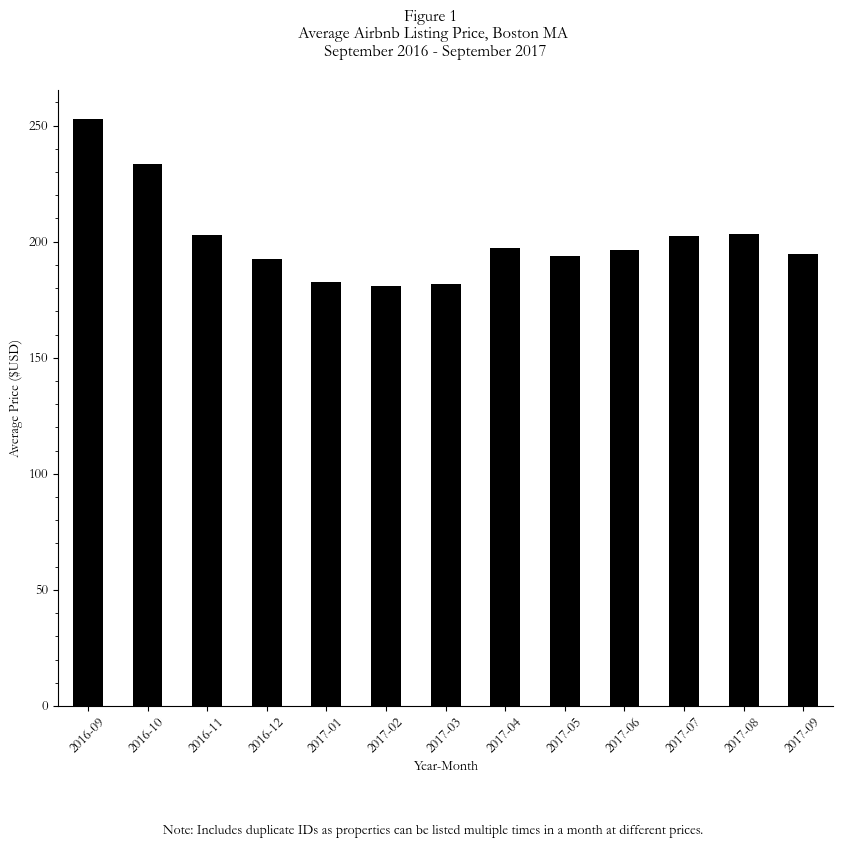

In [1904]:
#Calculate the average listing price per month

#Calculate mean price per year-month
avg_list_price = CalLisCrime.groupby("year_month")["price"] \
                            .mean().reset_index()

#Convert "year_month" column to string
avg_list_price["year_month"] = avg_list_price["year_month"].astype(str)

#Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
avg_list_price.plot(x="year_month", y="price", kind="bar", ax=ax, 
                    legend=False, color="black")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create title
fig.suptitle("Figure 1 \n Average Airbnb Listing Price, \
Boston MA \n September 2016 - September 2017")

#Set x label
ax.set_xlabel("Year-Month")

#Rotate x labels
plt.xticks(rotation=45)

#Set y label
ax.set_ylabel("Average Price ($USD)")

#Set y ticks to incriments of 50 for major ticks, 
#and set minor ticks to incriments of 10
ax.set_yticks(np.arange(0, 300, 50))  
ax.yaxis.set_minor_locator(mtick.MultipleLocator(10))  

#Create note
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can \
be listed multiple times in a month at different prices.", 
            ha="center", fontsize=10)

plt.show()

Figure 1 shows the monthly average Airbnb listing price in Boston over my period of interest.

I visualized this because it is necessary to see if the average listing price increased during the month of the Boston Marathon. The jump in average price in April 2017 supports my hypothesis. However, the high average prices in September and October of 2016 make this April 2017 jump appear less significant. This outcome could be due to seasonal variations in listing prices, or because only certain Airbnb's experience the marathon effect. It is therefore imperative to examine more granular data to better assess pricing trends.

## 4.2. Scatter Plot of Daily Average Airbnb Listing Price 

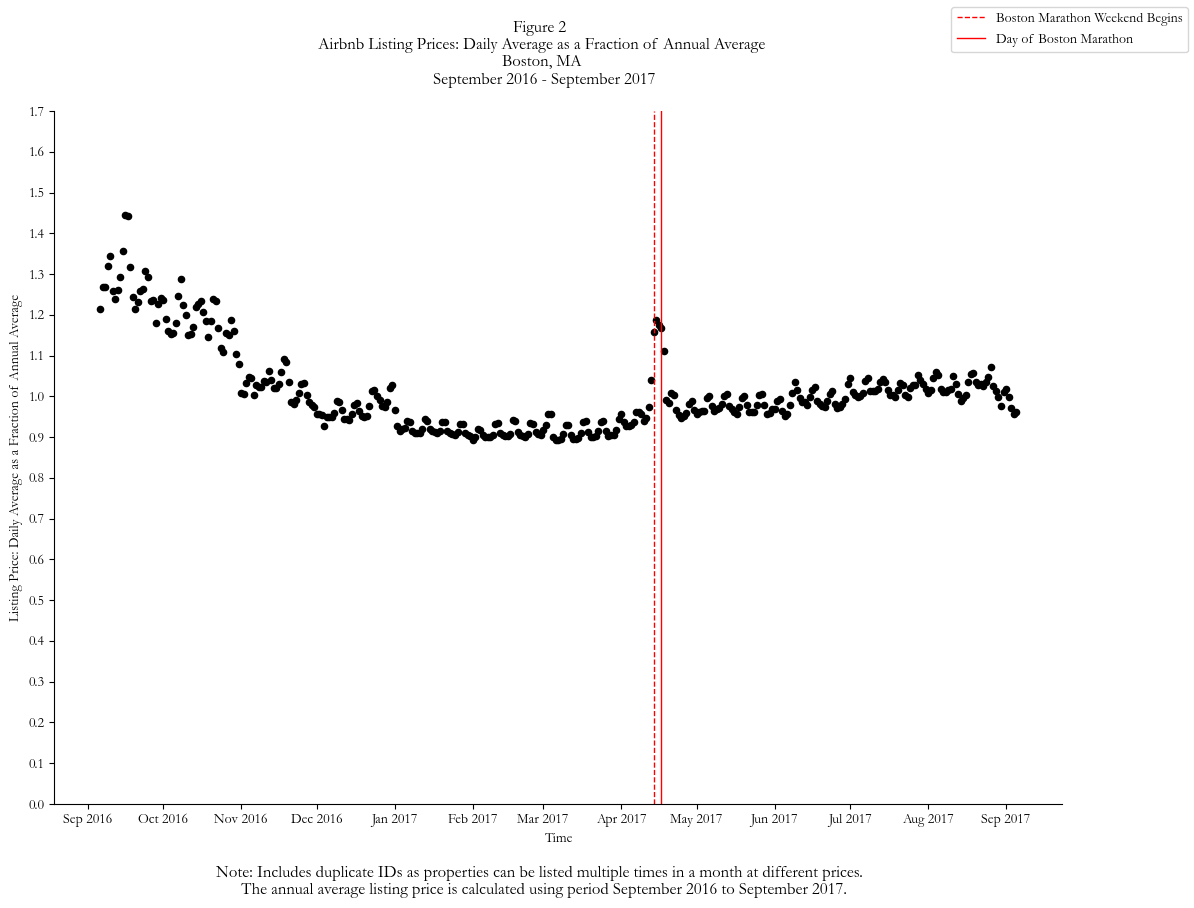

In [1905]:
#Create temp dataset of average listing price per day
temp = CalLisCrime.groupby("date")["price"].mean().reset_index()

#Calculate average price over the whole study period
avg_price_year = calendar["price"].mean()

#Create column in temp for average daily price as a fraction of average annual price
temp["price fraction"] = temp["price"] / avg_price_year

#Configure figure and axes
fig, ax = plt.subplots(figsize=(13, 9))

#Create line plot for average price per day
temp.plot(x="date", y="price fraction", ax=ax, kind="scatter", legend=True, color="black")

#Create vertical lines indicating the day the Boston Marathon weekend begins and the day of the Boston Marathon
ax.axvline(x=pd.to_datetime("2017-04-14"), color="red", linestyle="--", linewidth=1, 
           label="Boston Marathon Weekend Begins")
ax.axvline(x=pd.to_datetime("2017-04-17"), color="red", linestyle="-", linewidth=1, 
           label="Day of Boston Marathon")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#Create y label
ax.set_ylabel("Listing Price: Daily Average as a Fraction of Annual Average")

#Set y ticks
ax.set_yticks(np.arange(0, 1.8, 0.1))
ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1))

#Create x label
ax.set_xlabel("Time")

#Label every month on x-axis
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter("%b %Y"))

#Create title
fig.suptitle("Figure 2 \n Airbnb Listing Prices: \
Daily Average as a Fraction of Annual Average \n \
Boston, MA \n September 2016 - September 2017")

#Place legend in upper right corner
fig.legend(loc="upper right")

plt.figtext(0.5, 0.01, "Note: Includes duplicate IDs as properties can be \
listed multiple times in a month at different prices. \n The annual average \
listing price is calculated using period September 2016 to September 2017.", \
ha="center", fontsize=12)

plt.show()


Figure 2 presents daily average Airbnb listing prices as a fraction of the annual average.

I visualized this plot because it better highlights the spike in listing prices during the Boston Marathon period, which is indicated by the two red vertical lines. Noticeably, the price spike immediately vanishes following the day of the Boston Marathon.

## 4.3. Density Histograms of Airbnb Listing Prices by Time

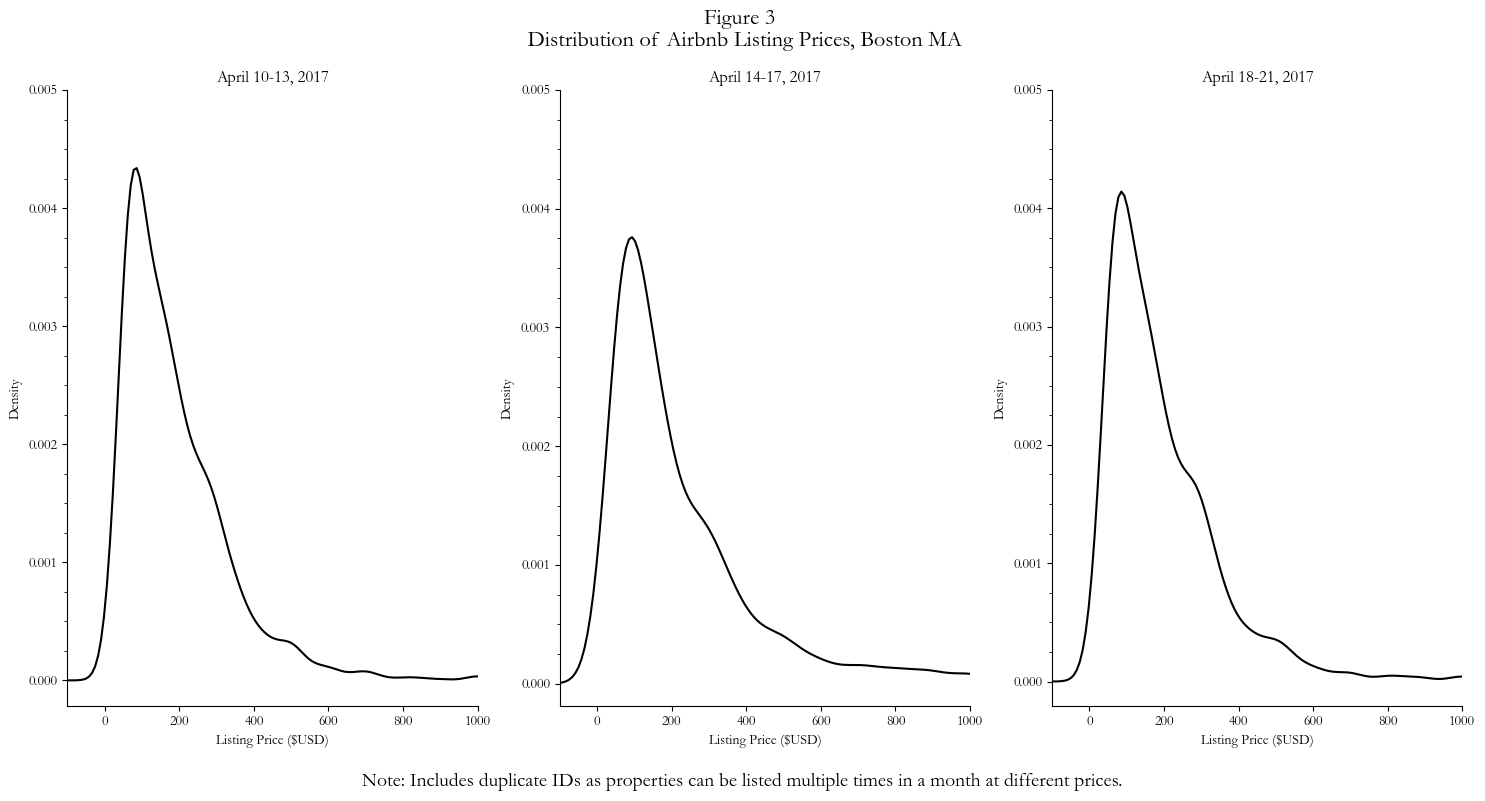

In [1906]:
#Create temp datasets for April 10-13, 2017, April 14-17, 2017, and April 18-21, 2017
april10_13 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-10") &
                            (CalLisCrime["date"] <= "2017-04-13")]
april14_17 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-14") &
                            (CalLisCrime["date"] <= "2017-04-17")]
april18_21 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-18") &
                            (CalLisCrime["date"] <= "2017-04-21")]

#Configure figure and axes, there are 3 axes and 1 figure
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

#Create April 10-13 histogram at axes[0]
april10_13.plot.density(y="price", ax=axes[0], legend=False, xlim=(-100, 1000), 
                   color="black") 

#Cleaning
#Remove right and top spines
axes[0].spines["right"].set_visible(False)   
axes[0].spines["top"].set_visible(False)

#Create title
axes[0].set_title("April 10-13, 2017")

#Create x label
axes[0].set_xlabel("Listing Price ($USD)")

#Set y ticks 
axes[0].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[0].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create April 14-17 histogram at axes[1]
april14_17.plot.density(y="price", ax=axes[1], legend=False, xlim=(-100, 1000), 
                   color = "black") 

#Cleaning
axes[1].spines["right"].set_visible(False)   
axes[1].spines["top"].set_visible(False)

axes[1].set_title("April 14-17, 2017")

axes[1].set_xlabel("Listing Price ($USD)")

axes[1].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[1].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create April 18-21 histogram at axes[1]
april18_21.plot.density(y="price", ax=axes[2], legend=False, xlim=(-100, 1000), 
                   color = "black") 

#Cleaning
axes[2].spines["right"].set_visible(False)   
axes[2].spines["top"].set_visible(False)

axes[2].set_title("April 18-21, 2017")

axes[2].set_xlabel("Listing Price ($USD)")

axes[2].set_yticks(np.arange(0, 0.0051, 0.001))  
axes[2].yaxis.set_minor_locator(mtick.MultipleLocator(0.00025)) 

#Create title
fig.suptitle("Figure 3 \n Distribution of Airbnb Listing Prices, Boston MA",
             fontsize=16)

#Create note
plt.figtext(0.5, 0.01, "Note: Includes duplicate IDs as properties can \
be listed multiple times in a month at different prices.", 
            ha="center", fontsize=14)
plt.show()

Figure 3 presents the distribution of Boston Airbnb listing prices for April 10th to the 21st, 2017.

I visualized this distribution to determine if there is a significant change in the distribution of prices due to the hypothesized demand surge brought about by the Boston Marathon. We see during the Boston Marathon period (April 14th to 17th) that the distribution of prices has a lower peak and a more gradual downward slope beyond this peak relative to both the before and after reference periods. This ultimately supports there being a temporary spike in prices due to the marathon. 

## 4.4. Box Plots of Airbnb Listing Prices by Distance to Marathon Finish Line and Time

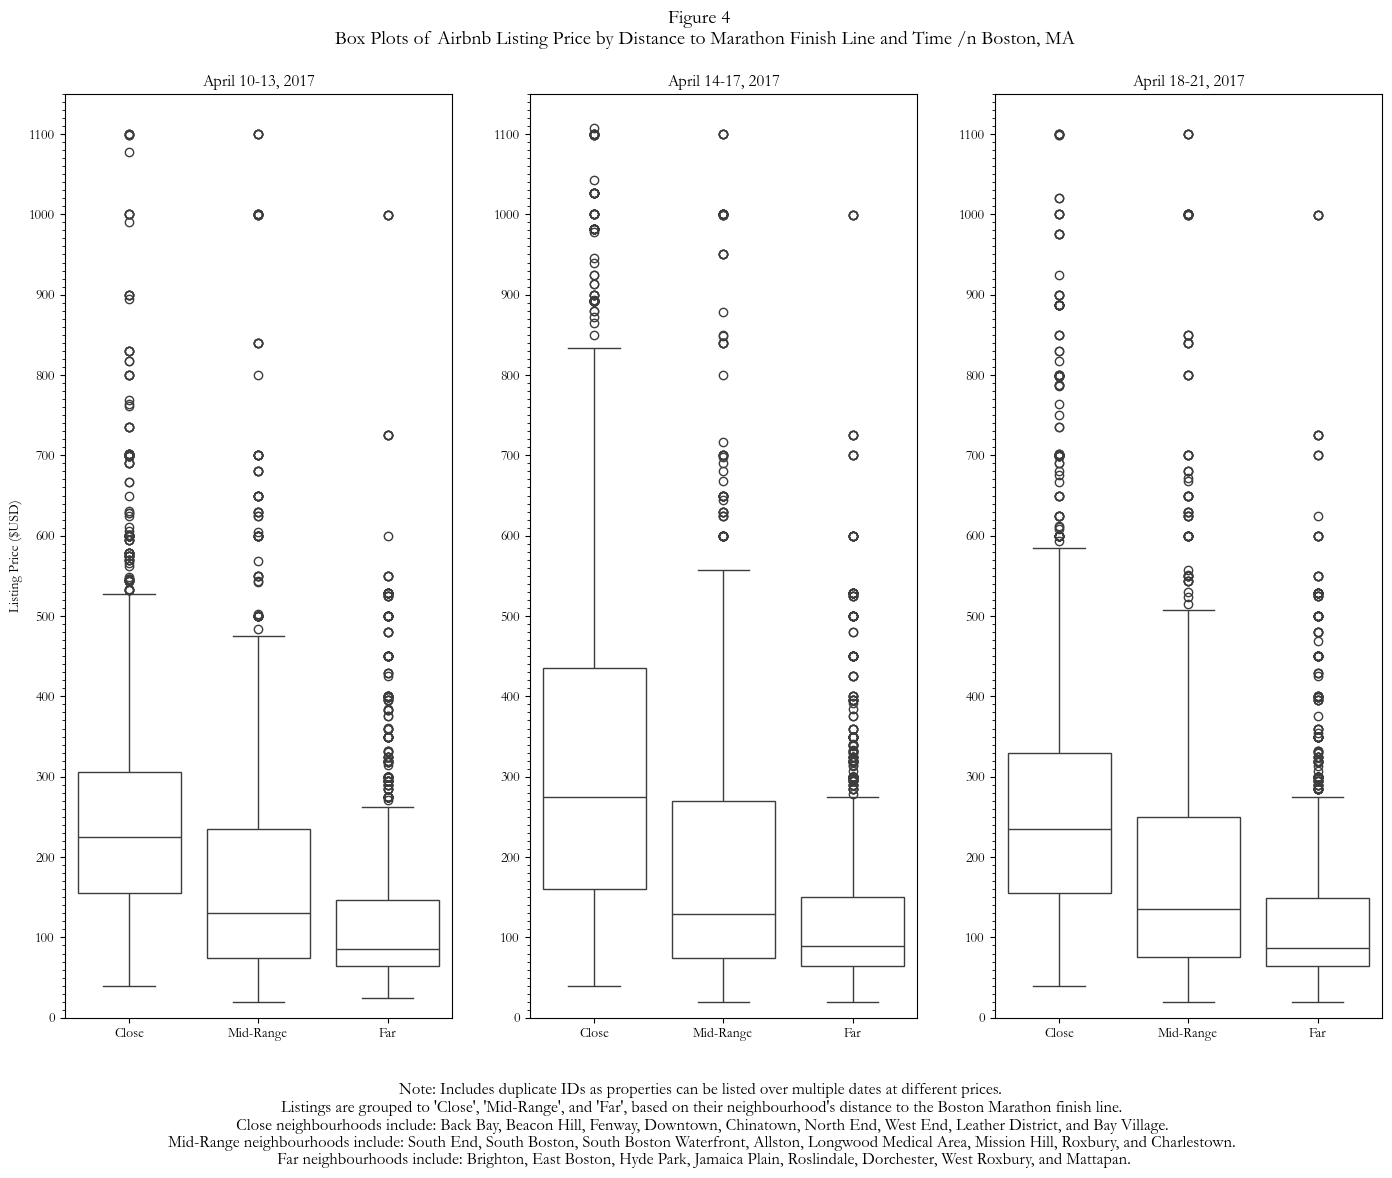

In [1907]:
#Idea sourced from: 
#https://www.kaggle.com/code/kostyabahshetsyan/boston-airbnb-visualization

#Create 3 lists for 'close', 'mid-range', and 'far' neighbourhoods
close = ["Back Bay", "Beacon Hill", "Fenway", "Downtown", "South End",
         "Chinatown", "North End", "West End", "Leather District", "Bay Village"]
mid_range = ["South Boston", "South Boston Waterfront",
             "Allston", "Longwood Medical Area", "Mission Hill",
             "Roxbury", "Charlestown"]
far = ["Brighton", "East Boston", "Hyde Park", "Jamaica Plain",
       "Roslindale", "Dorchester", "West Roxbury", "Mattapan"]

#Create filtered datasets for April 10-13, 2017, April 14-17, 2017, and April 18-21, 2017
april10_13 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-10") &
                            (CalLisCrime["date"] <= "2017-04-13")]
april14_17 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-14") &
                            (CalLisCrime["date"] <= "2017-04-17")]
april18_21 = CalLisCrime[(CalLisCrime["date"] >= "2017-04-18") &
                            (CalLisCrime["date"] <= "2017-04-21")]

#Configure figure and axes, there are 3 axes and 1 figure
fig, axes = plt.subplots(1, 3, figsize = (17, 12))

date = [april10_13, april14_17, april18_21]
date_str = ["April 10-13, 2017", "April 14-17, 2017", "April 18-21, 2017"]

index1 = 0
index2 = 0

for date in date:

       #Create dataset of April 10-13 by close, mid-range, and far neighbourhoods
       date_close = date[date["neighbourhood_cleansed"].isin(close)]
       date_mid_range = date[date["neighbourhood_cleansed"].isin(mid_range)]
       date_far = date[date["neighbourhood_cleansed"].isin(far)]

       #Keep only price column and rename price column to pice_close, price_mid_range, price_far
       date_close = date_close[["price"]].rename(columns={"price": "Close"})
       date_mid_range = date_mid_range[["price"]].rename(columns={"price": "Mid-Range"})
       date_far = date_far[["price"]].rename(columns={"price": "Far"})

       #Merge datasets 
       date_merged = pd.concat([date_close, date_mid_range, date_far], axis=1)

       sns.boxplot(data=date_merged, 
       ax=axes[index1], boxprops=dict(facecolor="none"))
       
       axes[index1].set_title(date_str[index2])

       axes[0].set_ylabel("Listing Price ($USD)")

       axes[index1].set_yticks(np.arange(0, 1151, 100)) 
       axes[index1].yaxis.set_minor_locator(mtick.MultipleLocator(10)) 

       axes[index1].set_ylim(0, 1150)
       
       index1 += 1
       index2 += 1

#Create title
fig.suptitle("Figure 4 \n Box Plots of Airbnb Listing Price by Distance to Marathon " \
              "Finish Line and Time /n Boston, MA", fontsize=14, y=0.95)

plt.figtext(0.5, -0.01, "Note: Includes duplicate IDs as properties can be \
listed over multiple dates at different prices. \n Listings are grouped to 'Close', \
'Mid-Range', and 'Far', based on their neighbourhood's distance to the Boston "
"Marathon finish line. \n \
Close neighbourhoods include: Back Bay, Beacon Hill, Fenway, Downtown, \
Chinatown, North End, West End, Leather District, and Bay Village. \n Mid-Range \
neighbourhoods include: South End, South Boston, South Boston Waterfront, \
Allston, Longwood Medical Area, Mission Hill, Roxbury, and Charlestown. \n \
Far neighbourhoods include: Brighton, East Boston, Hyde Park, Jamaica Plain, \
Roslindale, Dorchester, West Roxbury, and Mattapan.", 
ha="center", fontsize=12, wrap=True)

plt.show()


Figure 4 presents box plots of Airbnb listing prices for listings grouped by their neighbourhood's distance to the Boston Marathon finish line.

This figure allows me to assess if there was variation in the change in listing prices from before, during, and after the Boston Marathon period, based on a listing's distance to the Boston Marathon finish line. (Brady, 2017; City of Boston, 2009). This then helps me determine my treatment and control groups.

This figure shows that listings close to the Boston Marathon finish line had a noticeable change in the distribution of listing prices, with a higher median, 75th percentile, and upper whisker during the marathon period compared to before this period. Also, this change appears to immediately revert following the marathon period.

'Mid-range' listings, meanwhile, have a slightly increased 75th percentile and upper whisker during the marathon period. However, this reverts after the marathon. In contrast, there is not a noticeable change in the distribution of 'far' listings over all three periods.

This figure ultimately supports my hypothesis as it shows that 'close' listings experience a relatively large but temporary change in the distribution of listing prices during the marathon period relative to the two other listing groups. 

## 4.5. Line Plots of Average Listing Price for Select Neighbourhoods Over Time

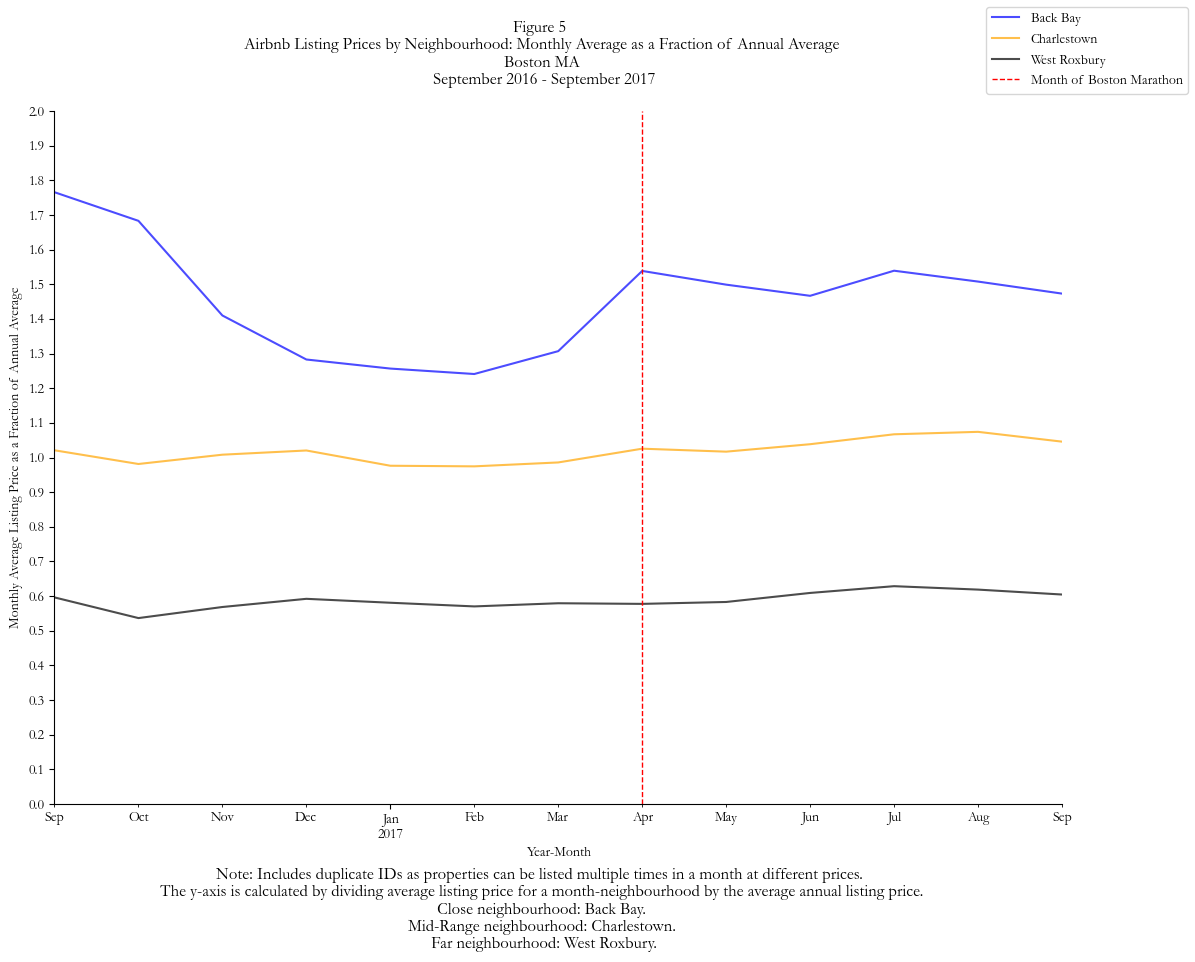

In [1908]:
#Group CalLisCrime by "neighbourhood_cleansed" and "year_month" and calculate
#average price
nei_price1 = CalLisCrime.groupby(["neighbourhood_cleansed", 
                                  "year_month"])["price"] \
                        .mean().reset_index()

#Calculate average price over the whole study period
avg_price_year = calendar["price"].mean()

#Create column in neigh_price1 called Price Standardized
nei_price1["price fraction"] = nei_price1["price"] / avg_price_year

#Create table of average price by neighbourhood for each month
nei_price1_pivot = nei_price1.pivot(index="year_month", 
                                    columns="neighbourhood_cleansed",
                                    values="price fraction")

#Configure figure and axes
fig, ax = plt.subplots(figsize=(13, 9))

#Create lines for average price by selected neighbourhood per month
nei_price1_pivot["Back Bay"].plot(ax=ax, alpha=0.7, legend=False, 
                                   color="blue")

nei_price1_pivot["Charlestown"].plot(ax=ax, alpha=0.7, legend=False, 
                                      color="orange")

nei_price1_pivot["West Roxbury"].plot(ax=ax, alpha=0.7, legend=False, 
                                       color="black")

#Create vertical line indicating the month of the Boston Marathon
ax.axvline(x="2017-04", color="red", linestyle="--", linewidth=1, 
           label="Month of Boston Marathon")

#Cleaning
#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create y label
ax.set_ylabel("Monthly Average Listing Price as a Fraction of Annual Average")

#Create x label
ax.set_xlabel("Year-Month")

#Create title
fig.suptitle("Figure 5 \n Airbnb Listing Prices by Neighbourhood: \
Monthly Average as a Fraction of Annual Average \n \
Boston MA \n September 2016 - September 2017")

#Set y ticks
ax.set_yticks(np.arange(0, 2.1, 0.1)) 
#ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.5)) 

#Place legend in upper right corner
fig.legend(loc="upper right")

#Create note
plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be \
listed multiple times in a month at different prices. \n The y-axis is calculated \
by dividing average listing price for a month-neighbourhood by the average annual listing \
price. \n Close neighbourhood: Back Bay. \n Mid-Range neighbourhood: Charlestown. \n \
Far neighbourhood: West Roxbury.", 
ha="center", fontsize=12)

plt.show()


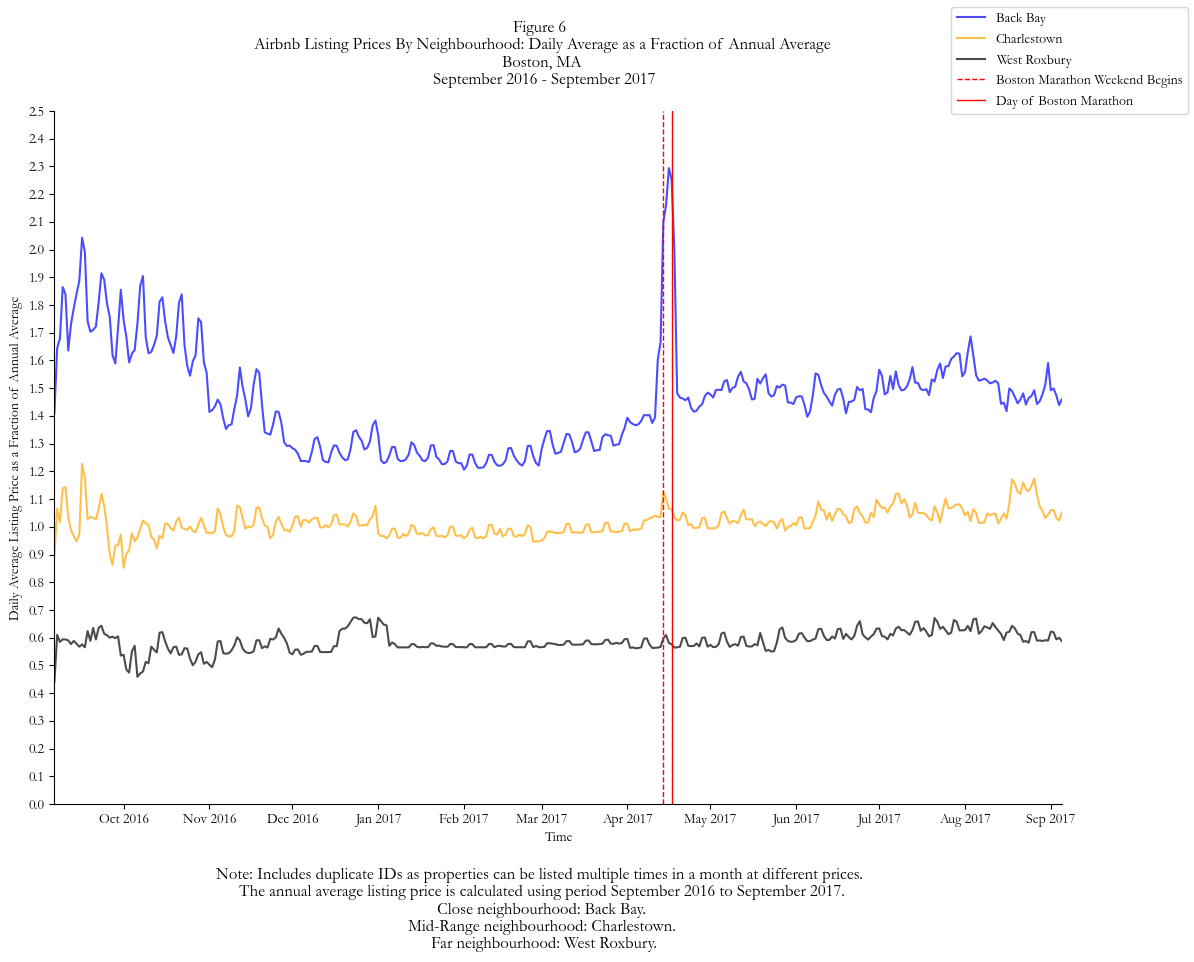

In [1909]:
#Group CalLisCrime by "neighbourhood_cleansed" and "date" and calculate
#average price
neigh_price2 = CalLisCrime.groupby(["neighbourhood_cleansed", "date"]) \
                            ["price"].mean().reset_index()

#Calculate average price over the whole study period
avg_price_year = calendar["price"].mean()

#Create column in neigh_price2 called average price as a percent of average annual price
neigh_price2["price fraction"] = neigh_price2["price"] / avg_price_year

#Create table of average price by neighbourhood for each day
neigh_price2_pivot = neigh_price2.pivot(index="date", 
                                        columns="neighbourhood_cleansed",
                                        values="price fraction")

#Configure figure and axes
fig, ax = plt.subplots(figsize=(13, 9))

#Create lines for average price by selected neighbourhood per day
neigh_price2_pivot["Back Bay"].plot(ax=ax, alpha=0.7, legend=False, 
                                    color="blue")
neigh_price2_pivot["Charlestown"].plot(ax=ax, alpha=0.7, legend=False, 
                                       color="orange")
neigh_price2_pivot["West Roxbury"].plot(ax=ax, alpha=0.7, legend=False, 
                                    color="black")


ax.axvline(x=pd.to_datetime("2017-04-14"), color="red", linestyle="--", linewidth=1, 
           label="Boston Marathon Weekend Begins")
ax.axvline(x=pd.to_datetime("2017-04-17"), color="red", linestyle="-", linewidth=1, 
           label="Day of Boston Marathon")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create y label
ax.set_ylabel("Daily Average Listing Price as a Fraction of Annual Average")

#Create x label
ax.set_xlabel("Time")

#Label x axis with month and year
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(mtick.NullLocator())

#Create title
fig.suptitle("Figure 6 \n Airbnb Listing Prices By Neighbourhood: \
Daily Average as a Fraction of Annual Average \
\n Boston, MA \n September 2016 - September 2017")

#Set y ticks
ax.set_yticks(np.arange(0, 2.51, 0.1)) 
ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1)) 

#Place legend in upper right corner
fig.legend(loc="upper right")

plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be \
listed multiple times in a month at different prices. \n The annual average \
listing price is calculated using period September 2016 to September 2017. \
\n Close neighbourhood: Back Bay. \n Mid-Range neighbourhood: Charlestown. \n \
Far neighbourhood: West Roxbury.", 
ha="center", fontsize=12)

plt.show()

Figures 5 and 6 present monthly and daily average Airbnb listing prices respectively for select neighbourhoods from the 'close', 'mid-range', and 'far' groups first introduced in Figure 3. 

These figures support my hypothesis and research design as Back Bay’s daily average listing price jumps during the marathon period while no similar trend is observed for the 'mid-range' and 'far' neighbourhoods. 

# Project 2

## 5. The Message

In Boston, MA, in 2017, there was likely a 'Boston Marathon effect' on Airbnb listing prices that only listings close to the marathon experienced significantly. This then allows me to assign 'close' listings a treatment group and 'mid-range' and 'far' listings to a control group to ultimately conduct a panel difference-in-differences regression analysis to both measure the causal effect of the Boston Marathon on Airbnb listing prices and determine if superhosts varied in their 'marathon pricing behaviour' compared to non-superhosts. 

See Figure 7 below for a visual representation of how this 'marathon effect' appears isolated mainly to 'close' listings.

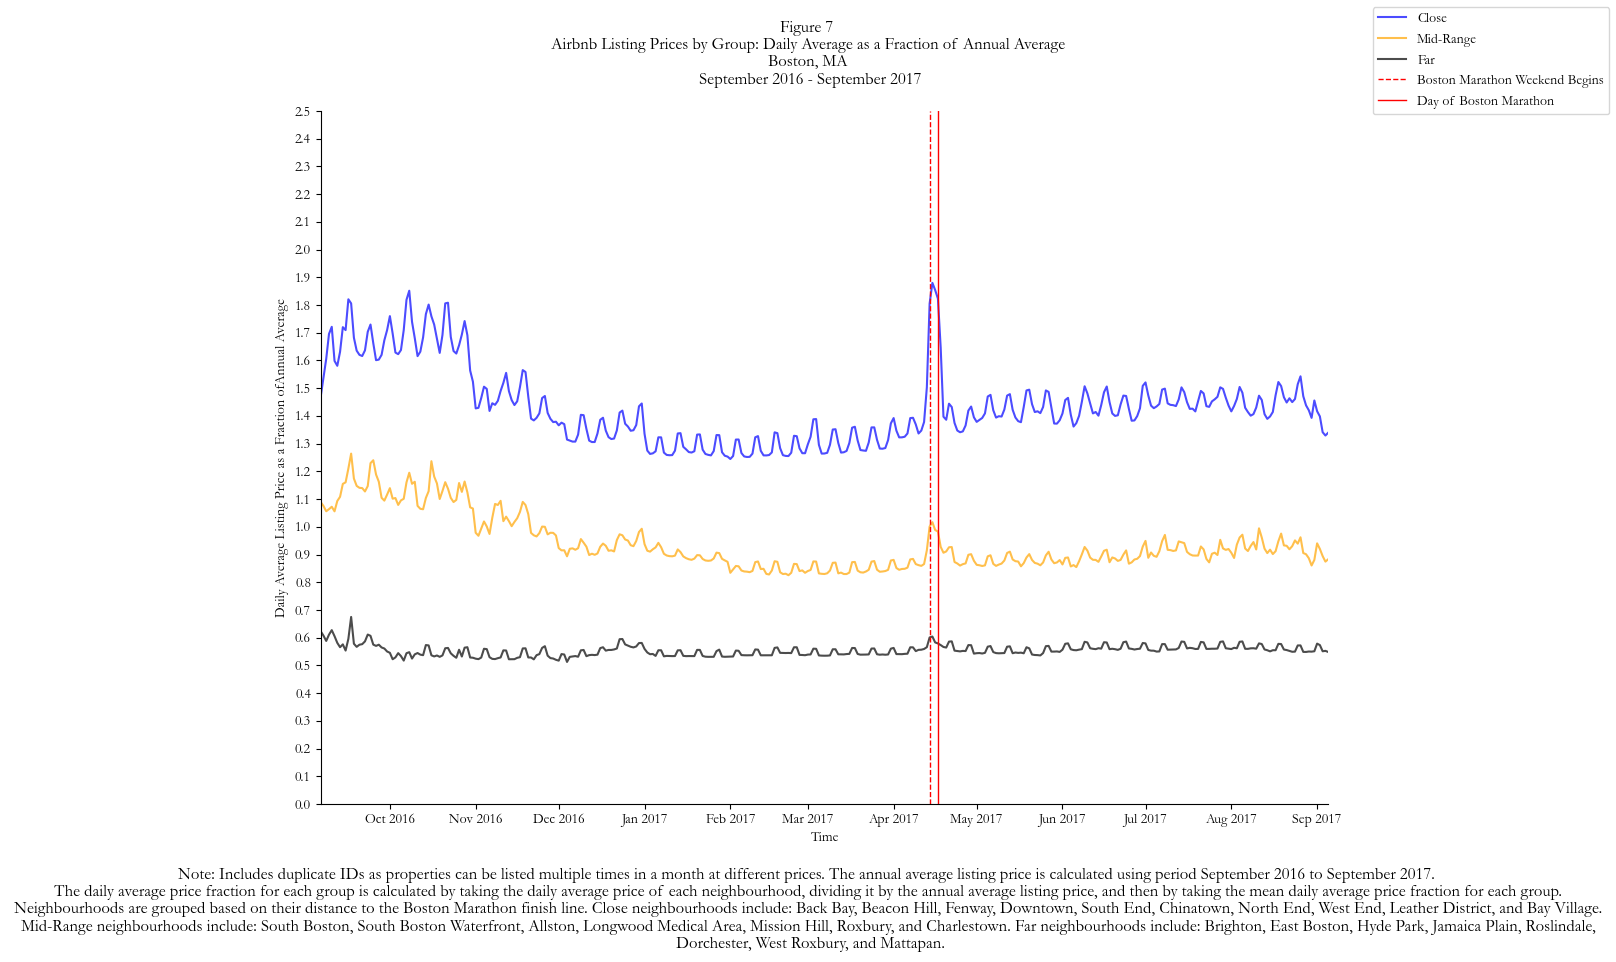

In [1910]:
message_frame = CalLisCrime.copy()

#Get daily average price for each neighbourhood
message_frame = message_frame.groupby(["neighbourhood_cleansed", "date"]) \
                            ["price"].mean().reset_index()

#Calculate daily average as a fraction of annual average price
avg_price_year = calendar["price"].mean()
message_frame["price fraction"] = message_frame["price"] / avg_price_year

close = ["Back Bay", "Beacon Hill", "Fenway", "Downtown", "South End",
         "Chinatown", "North End", "West End", "Leather District", "Bay Village"]
mid_range = ["South Boston", "South Boston Waterfront",
             "Allston", "Longwood Medical Area", "Mission Hill",
             "Roxbury", "Charlestown"]
far = ["Brighton", "East Boston", "Hyde Park", "Jamaica Plain",
       "Roslindale", "Dorchester", "West Roxbury", "Mattapan"]

#Create filtered datasets for close, mid-range, and far neighbourhoods
close = message_frame[message_frame["neighbourhood_cleansed"].isin(close)]
mid_range = message_frame[message_frame["neighbourhood_cleansed"].isin(mid_range)]
far = message_frame[message_frame["neighbourhood_cleansed"].isin(far)]

#Configure figure and axes
fig, ax = plt.subplots(figsize=(13, 9))

#Get mean price fraction for each day among neighbourhoods in close, mid-range, and far
close.groupby("date")["price fraction"].mean().plot(ax=ax, alpha=0.7, label="Close", 
                                                     legend=False, color="blue")
mid_range.groupby("date")["price fraction"].mean().plot(ax=ax, alpha=0.7, label="Mid-Range",
                                                        legend=False, color="orange")
far.groupby("date")["price fraction"].mean().plot(ax=ax, alpha=0.7, label="Far",
                                                   legend=False, color="black")

#Create vertical line indicating the friday before the Boston Marathon 
# and the day of the Boston Marathon
ax.axvline(x=pd.to_datetime("2017-04-14"), color="red", linestyle="--", linewidth=1, 
           label="Boston Marathon Weekend Begins")
ax.axvline(x=pd.to_datetime("2017-04-17"), color="red", linestyle="-", linewidth=1,
           label="Day of Boston Marathon")

#Cleaning

#Remove right and top spines
ax.spines["right"].set_visible(False)   
ax.spines["top"].set_visible(False)

#Create y label
ax.set_ylabel("Daily Average Listing Price as a Fraction ofAnnual Average")

#Create x label
ax.set_xlabel("Time")

#Label x axis with month and year
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(mtick.NullLocator())

#Create title
fig.suptitle("Figure 7 \n Airbnb Listing Prices by Group: \
Daily Average as a Fraction of Annual Average \
\n Boston, MA \n September 2016 - September 2017")

#Set y ticks
ax.set_yticks(np.arange(0, 2.51, 0.1)) 
ax.yaxis.set_minor_locator(mtick.MultipleLocator(0.1)) 

#Place legend in upper right corner
fig.legend(loc="upper right")

plt.figtext(0.5, -0.05, "Note: Includes duplicate IDs as properties can be "
                        "listed multiple times in a month at different prices. The annual average "
                        "listing price is calculated using period September 2016 to September 2017. "
                        "\n The daily average price fraction for each group is calculated by taking the "
                        "daily average price of each neighbourhood, dividing it by the annual average listing price, and then "
                        "by taking the mean daily average price fraction for each group. \n "
                        "Neighbourhoods are grouped based on their distance to the Boston Marathon finish line. "
                        "Close neighbourhoods include: Back Bay, Beacon Hill, Fenway, Downtown, South End, "
                        "Chinatown, North End, West End, Leather District, and Bay Village. "
                        "\n Mid-Range neighbourhoods include: South Boston, South Boston Waterfront, Allston, "
                        "Longwood Medical Area, Mission Hill, Roxbury, and Charlestown. "
                        "Far neighbourhoods include: Brighton, East Boston, Hyde Park, Jamaica Plain, "
                        "Roslindale, \n Dorchester, West Roxbury, and Mattapan.", 
             ha="center", fontsize=12)

plt.show()



# 6. Maps

## 6.1. Boston Neighbourhoods' Airbnb Density

In [1911]:
#Obtained from: https://data.boston.gov/dataset/neighborhood-demographics
population_by_neighbourhood = {
    "Allston": 19261,
    "Brighton": 55297,
    "Charlestown": 19890,
    "Dorchester": 126909,
    "Downtown": 18306,
    "East Boston": 47263,
    "Fenway": 33489,
    "Hyde Park": 38924,
    "Jamaica Plain": 40867,
    "Longwood": 5351,
    "Mattapan": 26659,
    "Mission Hill": 17386,
    "North End": 8749,
    "Roslindale": 30021,
    "Roxbury": 54161,
    "South Boston": 36772,
    "South Boston Waterfront": 4403,
    "South End": 32571,
    "West End": 6619,
    "West Roxbury": 33526
}

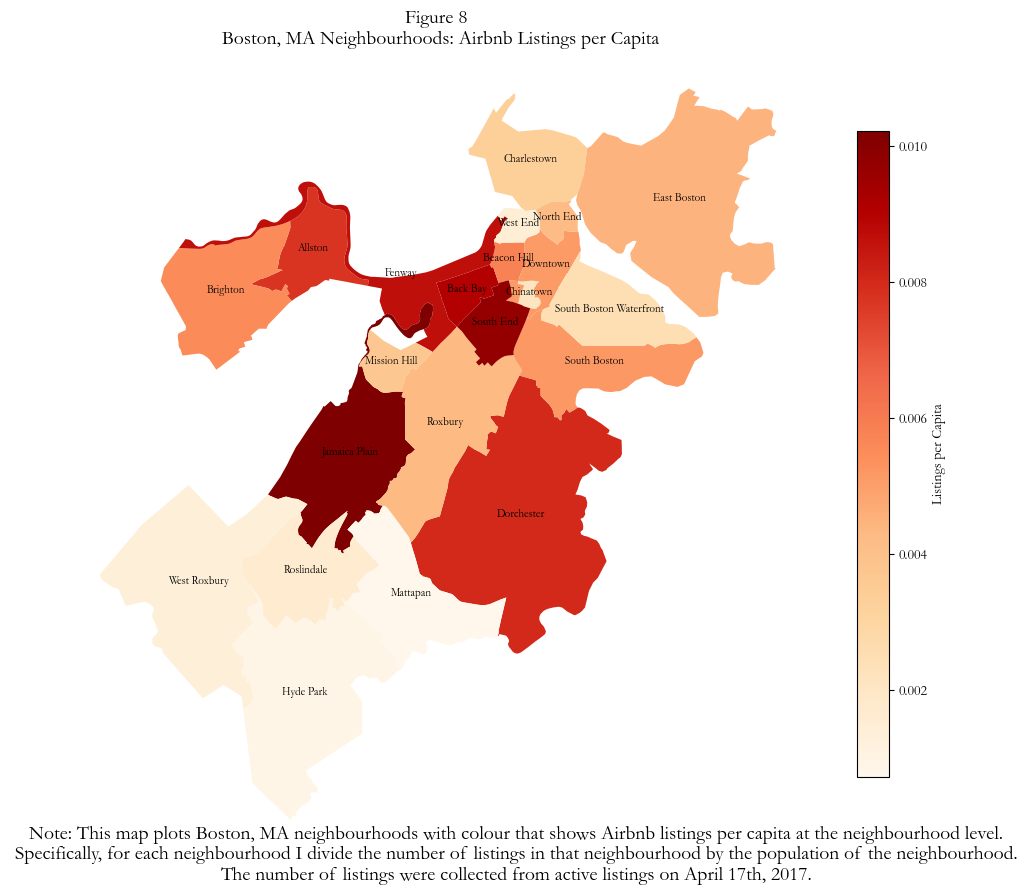

In [1912]:
nei_capita = CalLisCrime.copy()

# Filter for April 17th, 2017
nei_capita = nei_capita[nei_capita["date"] == "2017-04-17"]

# Drop duplicate listings
nei_capita = nei_capita.drop_duplicates(subset=["id"], keep="first")

# Group by neighbourhood and count unique properties per neighbourhood
nei_capita = nei_capita.groupby("neighbourhood_cleansed")["id"].count() \
                    .reset_index()

#Rename columns
nei_capita.rename(columns={"id": "count", "neighbourhood_cleansed": "neighborhood"}, 
                 inplace=True)

boston_neighbourhoods = gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\"
    "Eco225\\ECO225Project\\"
    "boston_neighborhood_boundaries_approximated_by_2020_census_tracts.json")

#Merge datasets
nei_capita = nei_capita.merge(boston_neighbourhoods, on="neighborhood", how="left")

#Divide count by population to get Airbnb listings per capita
for population in population_by_neighbourhood:
        nei_capita["Listings per Capita"] = nei_capita["count"] / \
            population_by_neighbourhood[population]

#Drop rows with NaN geometry
nei_capita = nei_capita.dropna(subset=["geometry"])

#Convert to GeoDataFrame
nei_capita = gpd.GeoDataFrame(nei_capita, geometry="geometry")

#Convert epsg to 32619
nei_capita = nei_capita.to_crs(epsg=32619)

fig, gax = plt.subplots(figsize=(12, 12))

#Plot neighbourhoods with color for share of listings
nei_capita.plot(column="Listings per Capita", cmap="OrRd", ax=gax, legend=True, 
               legend_kwds={"label": "Listings per Capita", 
                            "shrink": 0.7})

#Label neighbourhoods
#Centroid: 
#https://shapely.readthedocs.io/en/2.0.6/reference/shapely.centroid.html
for x, y, label in zip(nei_capita.geometry.centroid.x, 
                       nei_capita.geometry.centroid.y, 
                       nei_capita["neighborhood"]): 
        gax.text(x, y, label, fontsize=8, ha="center")

#Cleaning
#Remove all spines
gax.spines["top"].set_visible(False)
gax.spines["right"].set_visible(False)
gax.spines["left"].set_visible(False)
gax.spines["bottom"].set_visible(False)

#Remove x ticks
gax.set_xticks([])
gax.set_yticks([])

gax.set_title("Figure 8 \n Boston, MA Neighbourhoods: Airbnb Listings per Capita",
              fontsize=14)

#Add a note
plt.figtext(0.5, 0.14, "Note: This map plots Boston, MA neighbourhoods with colour " \
            "that shows Airbnb listings per capita at the neighbourhood level." \
            "\n Specifically, for each neighbourhood I divide the number of listings in " \
            "that neighbourhood by the population of the neighbourhood. \n" \
            "The number of listings were collected from active listings on April 17th, 2017.", 
            ha="center", fontsize=14)

plt.show()

Figure 8 maps Boston neighbourhoods using color to represent Airbnb listings per capita at the neighbourhood level. 

This visualization highlights the significant presence of Airbnb's in the downtown region, especially in Back Bay, Fenway, and the South End, relative to neighbourhoods, such as West Roxbury, that are far from the downtown core. This makes sense as the downtown areas likely attract more tourists who are seeking short term rentals. Interestingly, Jamaica Plain and Dorchester exhibit a noticeably higher Airbnb presence compared to other 'mid-range' neighbourhoods like Roxbury. 

Ultimately, this map allows me to identify which neighbourhoods primarily drive Airbnb listing price trends, as neighbourhoods with more listings per capita will exert greater influence on price dynamics.

## 6.2. Boston Airbnb Listings: Percent Change in Price Before & During the Boston Marathon

In [1913]:
# Create 2 temp datasets which only includes a day the week before the marathon and
#the day of the marathon
# Only keep the id and price columns
pre_marathon = CalLisCrime[CalLisCrime["date"] == "2017-04-10"][["id", "price"]]
during_marathon = CalLisCrime[CalLisCrime["date"] == "2017-04-17"][["id", "price"]]

# Rename columns
pre_marathon.rename(columns={"price": "pre_marathon_price"}, inplace=True)
during_marathon.rename(columns={"price": "during_marathon_price"}, inplace=True)

# Merge the two dataframes on id
price_comparison = pre_marathon.merge(during_marathon, on="id", how="inner")

#Drop properties with NaN values
price_comparison.dropna(inplace=True)

#Calculate the difference in price
price_comparison["Difference"] = price_comparison["during_marathon_price"] \
      - price_comparison["pre_marathon_price"]

#Create column for percent change in price
price_comparison["Percent Change"] = (price_comparison["Difference"] \
                                       / price_comparison["pre_marathon_price"]) \
                                     * 100

#Drop outliers (ie. if % change > 300%)
price_comparison = price_comparison[price_comparison["Percent Change"] <= 300]

price_comparison.set_index("id", inplace=True)

In [1914]:
#Create temp dataset which has latitude, longitude, and id of
#each property
temp1 = CalLisCrime[["id", "latitude", "longitude"]].copy()

#Zip latitude and longitude to create property_coords column
temp1["property_coords"] = list(zip(temp1.longitude, temp1.latitude))

#Drop duplicate listings
temp1.drop_duplicates(subset=["id"], keep="last", inplace=True)

#Keep only id and property_coords columns
temp1 = temp1[["id", "property_coords"]]

#Drop rows with NaN id
temp1.dropna(subset=["id"], inplace=True)

#Set index to id
temp1.set_index("id", inplace=True)

#Merge temp1 with price_comparison to have property_coords with the 
#price comparison dataset
price_comparison = price_comparison.merge(temp1, on="id", how="right")

#Drop if 0 in difference column
price_comparison1 = price_comparison[price_comparison["Difference"] != 0]

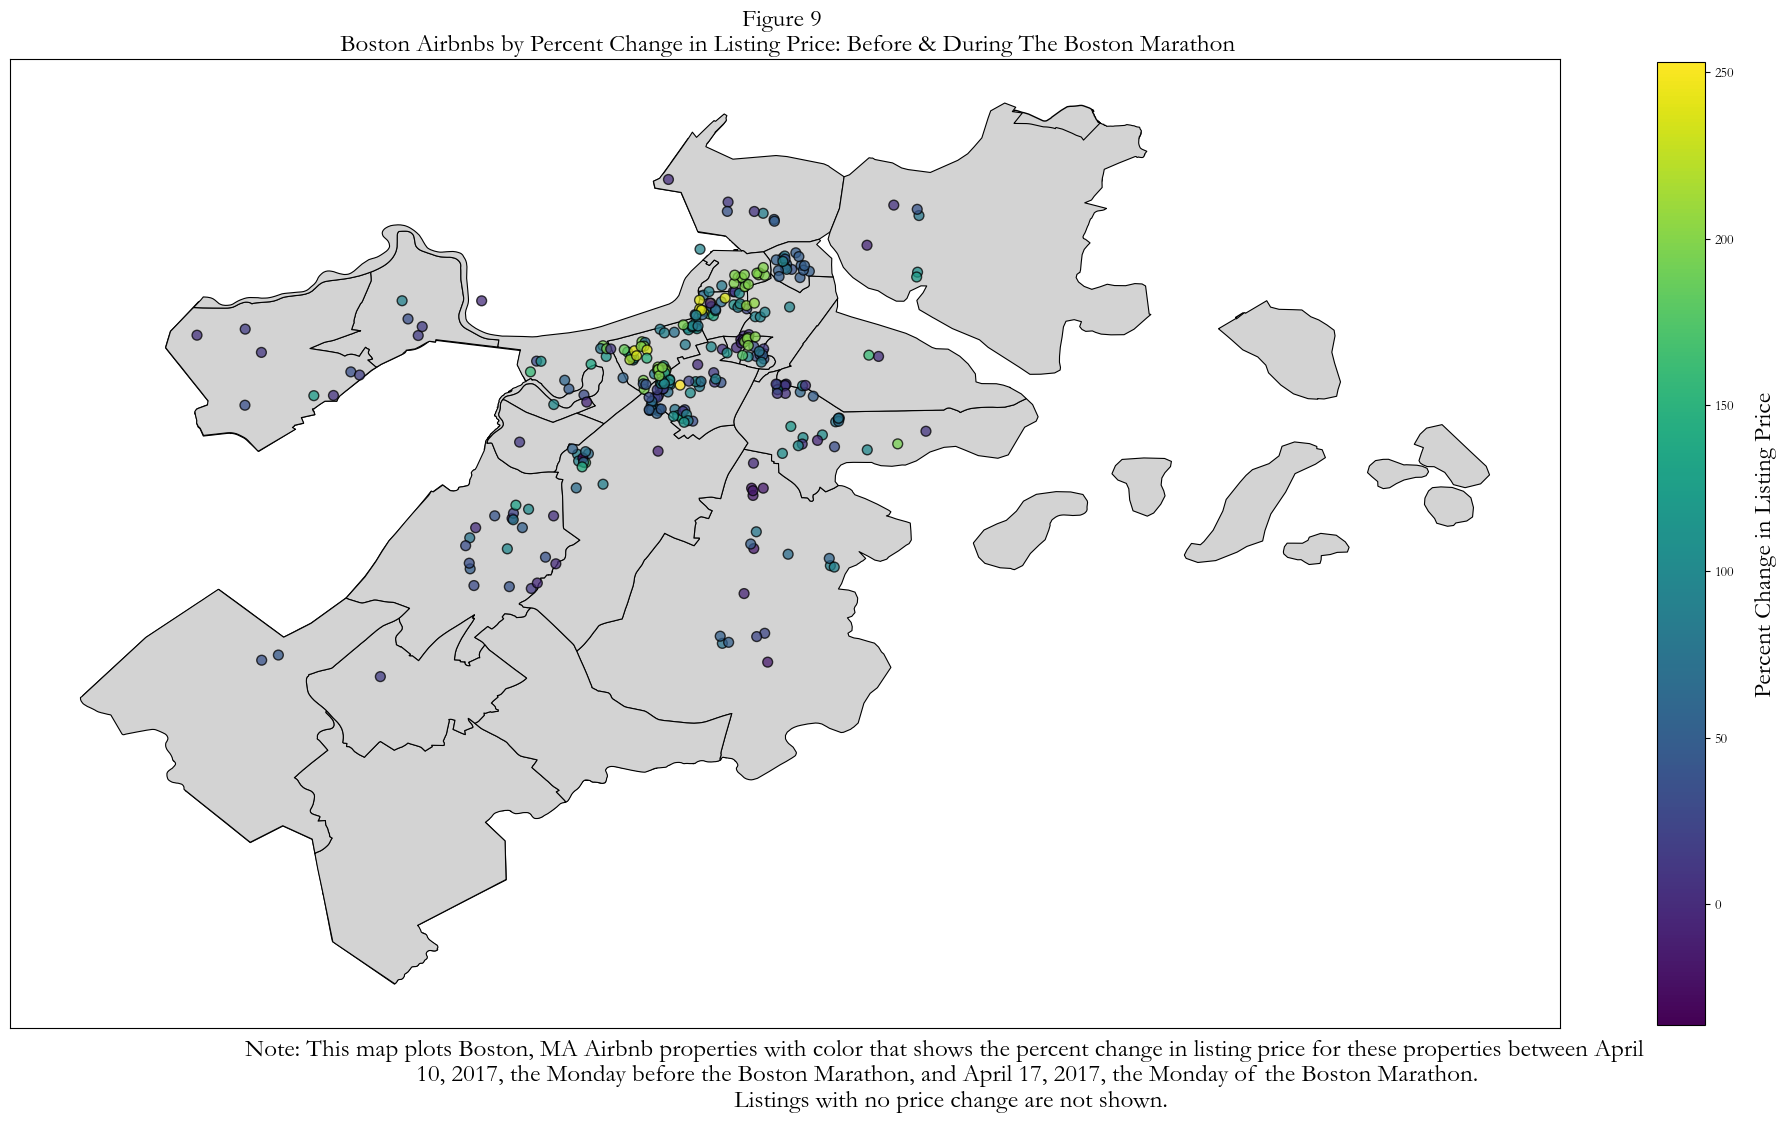

In [1915]:
#Prevents setting with copy warning
price_comparison1 = price_comparison1.copy()

#Convert property_coords to Point
price_comparison1["property_coords"] = price_comparison1["property_coords"].apply(Point)

#Convert price_comparison1 to GeoDataFrame called price_comparison_geo
price_comparison_geo = gpd.GeoDataFrame(price_comparison1, \
                                        geometry="property_coords")

boston = gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\ECO225Project\\"
                        "city_of_boston_outline_boundary_water_excluded.json")

boston_neighbourhoods = \
gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\ECO225Project\\"
            "boston_neighborhood_boundaries_approximated_by_2020_census_tracts.json")

# Create the plot
fig, gax = plt.subplots(figsize=(25, 25))

boston.plot(ax=gax, edgecolor="black", linewidth=1, color="lightgrey")

#Plot boston_neighbourhoods
boston_neighbourhoods.plot(ax=gax, edgecolor="black", linewidth=0.8,
                           color="lightgrey")

#Plot price_comparison_geo and create a color gradient for percent change
price_comparison_geo.plot( ax=gax, column="Percent Change", cmap="viridis", 
    markersize=50, edgecolor="black", alpha=0.75, legend=True,
    legend_kwds={"label": "Percent Change in Listing Price", "shrink": 0.5})

#Cleaning

#Clean color bar
cbar = gax.get_figure().get_axes()[1] 
cbar.set_ylabel("Percent Change in Listing Price", fontsize=18, labelpad=15)

#Create title
gax.set_title("Figure 9 \n Boston Airbnbs by Percent Change in Listing Price: " \
               "Before & During The Boston Marathon", 
              fontsize=18)

#Remove ticks
gax.set_xticks([])
gax.set_yticks([])

#Add a note
plt.figtext(0.5, 0.27, "Note: This map plots Boston, MA Airbnb properties with color that " \
            "shows the percent change in listing price for these properties between April \n " \
            "10, 2017, the Monday before the Boston Marathon, and April 17, 2017, the " \
            "Monday of the Boston Marathon. \n Listings with no price change " \
            "are not shown.", ha="center", fontsize=18)

plt.show()

Figure 9 maps Boston Airbnb properties using color to show the percent change in listing price for these properties between April 10th, 2017, the Monday before the Boston Marathon, and April 17th, 2017, the day of the marathon. Importantly, listings with no price change are not shown.

This map demonstrates that most listings which altered their price were in the downtown core. We can see that some listings in the downtown core increased their price by as much as 200 to 250 percent. In contrast, listings farther from the downtown core, which do have a change in price, are mostly concentrated in the 'mid-range' group of neighbourhoods. However, these 'mid-range' listings do not increase their prices by as much compared to downtown listings. There is also only a handful of listings in the 'far' group of neighbourhoods which change their price in response to the marathon. 

This map supports my hypothesis that it was mostly Airbnb listings near the downtown Boston Marathon route which increased their prices in response to a hypothesized demand surge brought about by the Boston Marathon.

## 6.3. Boston Airbnbs: Average Change in Price by Neighbourhood

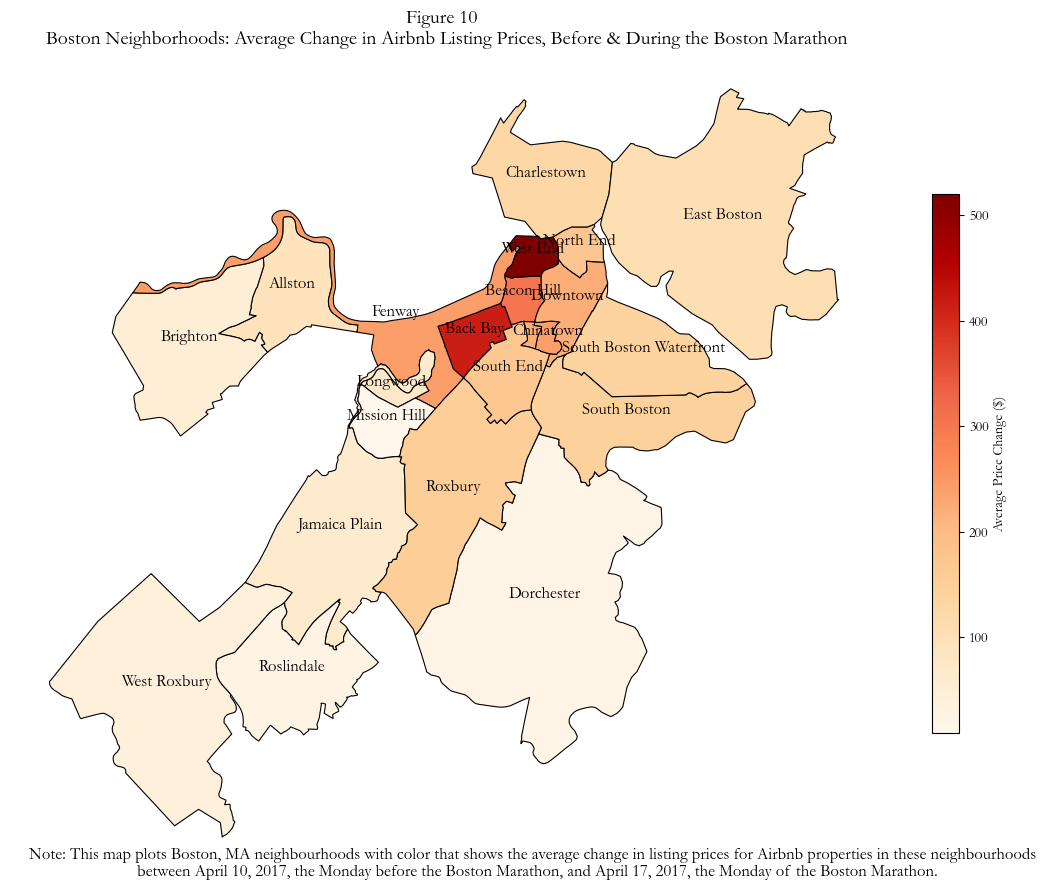

In [1916]:
boston_neighbourhoods = \
gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\ECO225Project\\"
            "boston_neighborhood_boundaries_approximated_by_2020_census_tracts.json")

#Documentation: https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html
price_comparison_geo.set_crs(epsg=4326, inplace=True)
price_comparison_geo = gpd.sjoin(price_comparison_geo, 
                    boston_neighbourhoods, how="left", predicate="within")

#Group price_comparison_geo by neighbourhood and calculate average price change
#Store results in neighborhood_price_change
neighborhood_price_change = price_comparison_geo.groupby(
    price_comparison_geo["neighborhood"])["Difference"].mean().reset_index()

#Merge neighborhood_price_change with boston_neighbourhoods
boston_neighborhoods = boston_neighbourhoods.merge(
    neighborhood_price_change, on="neighborhood", how="left")

#Get centroid of each neighbourhood
boston_neighborhoods = boston_neighborhoods.to_crs(epsg=26986) 
boston_neighborhoods["centroid"] = boston_neighborhoods.geometry.centroid  
boston_neighborhoods["centroid"] = boston_neighborhoods["centroid"].to_crs(
    epsg=4326)
boston_neighborhoods = boston_neighborhoods.to_crs(epsg=4326)

#Create plot
fig, ax = plt.subplots(figsize=(14, 14))

#Plot neighbourhoods with color for average price change
boston_neighborhoods.plot(ax=ax, column="Difference", cmap="OrRd",
    edgecolor="black", linewidth=0.8, legend=True,
    legend_kwds={"label": "Average Price Change ($)", "shrink": 0.5}
)

#Create list of unique neighbourhoods
valid_neighborhoods = boston_neighborhoods["neighborhood"].unique()
#Drop Mattapan and Hyde Park 
valid_neighborhoods = valid_neighborhoods[valid_neighborhoods != "Mattapan"]
valid_neighborhoods = valid_neighborhoods[valid_neighborhoods != "Hyde Park"]

#Label neighbourhoods
for idx, row in boston_neighborhoods.iterrows():
    #Only label neighbourhoods in valid_neighbourhoods
    if row["neighborhood"] in valid_neighborhoods:  
        plt.annotate(
            text=row["neighborhood"],
            xy=(row["centroid"].x, row["centroid"].y),
            xytext=(0, 3),  
            textcoords="offset points",
            fontsize=12,
            color="black",
            ha="center"
        )

#Remove spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

#Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Labels and title
ax.set_title("Figure 10 \n "
"Boston Neighborhoods: Average Change in Airbnb Listing Prices, " \
"Before & During the Boston Marathon", 
fontsize=14)

plt.figtext(0.5, 0.2, "Note: This map plots Boston, MA neighbourhoods with color that " \
            "shows the average change in listing prices for Airbnb properties in these neighbourhoods " \
            "\n between April 10, 2017, the Monday before the Boston Marathon, and April 17, "
            "2017, the Monday of the Boston Marathon.", ha="center", fontsize=12)

plt.show()


Figure 10 maps Boston neighbourhoods with color to show the average change in listing prices for Airbnb properties in these neighbourhoods between April 10th, 2017, the Monday before the Boston Marathon, and April 17th, 2017, the day of the marathon.

As shown above, this map demonstrates that downtown neighbourhoods had a higher average price change in response to the marathon relative to 'mid-range' neighbourhoods and 'far' neighbourhoods. Once again, this supports my hypothesis that only 'close' neighbourhoods experienced a 'marathon effect'.

## 6.4. Map of Boston Neighbourhoods by Share of Crime

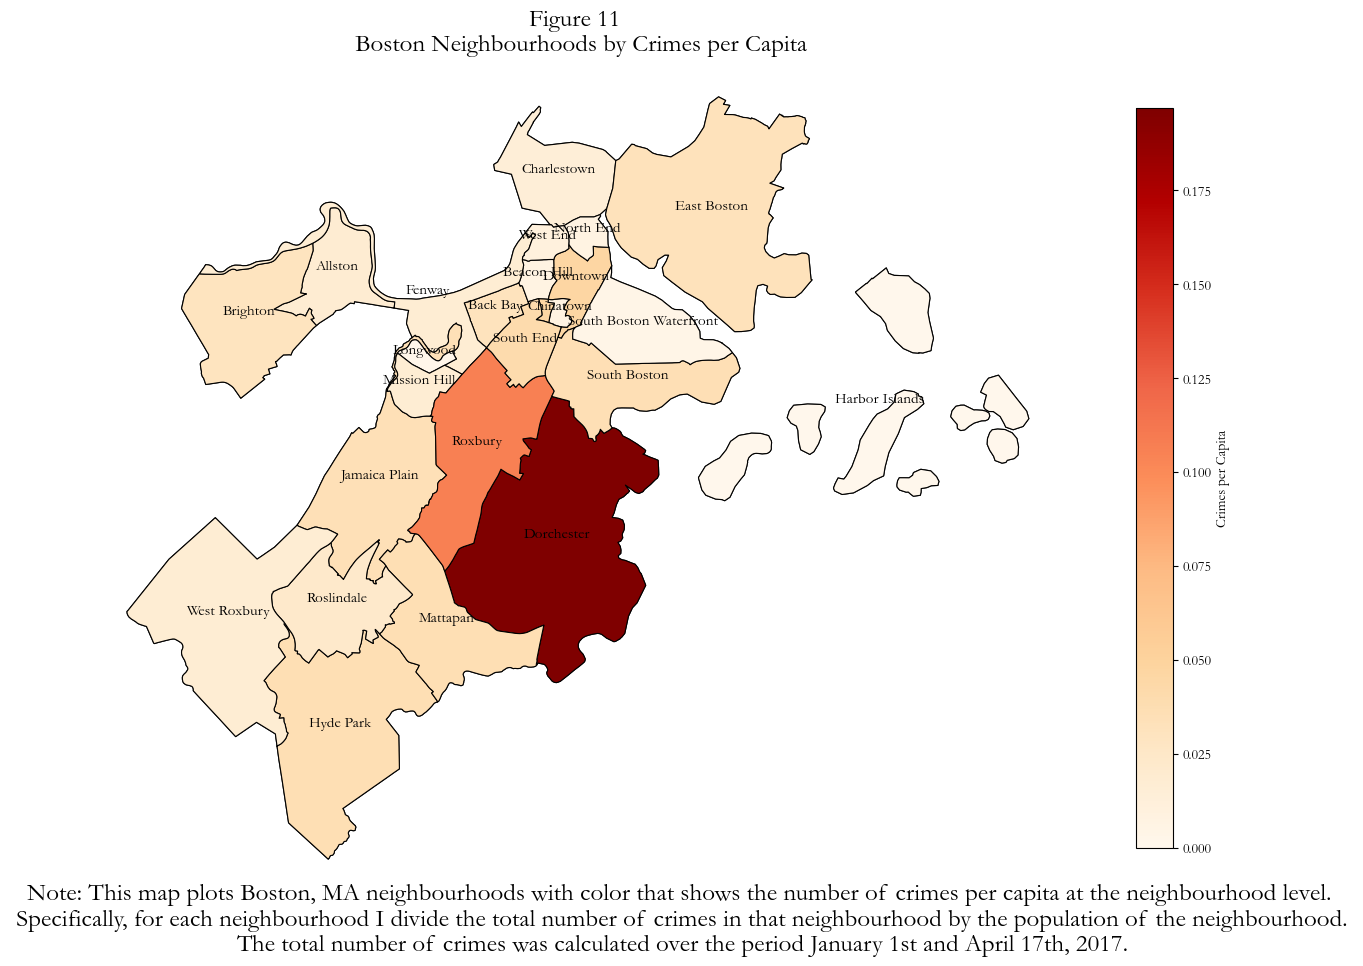

In [1917]:
crime_map = crime.copy()

#Convert OCCURRED_ON_DATE to datetime
crime_map["OCCURRED_ON_DATE"] = pd.to_datetime(crime_map["OCCURRED_ON_DATE"])

#Only keep data between January 1st, 2017 to April 17th, 2017
crime_map = crime_map[(crime_map["OCCURRED_ON_DATE"] >= "2017-01-01") & 
                      (crime_map["OCCURRED_ON_DATE"] <= "2017-04-17")]

#Convert Location to a tuple
crime_map["Location"] = crime_map["Location"].str.strip("()")
crime_map["Location"] = crime_map["Location"].str.split(", ")
crime_map["Location"] = crime_map["Location"].apply(lambda x: tuple(x))

#Apply point to Location
crime_map["Location"] = crime_map["Location"].apply(Point)
#Swap latitude and longitude in Location
crime_map["Location"] = crime_map["Location"].apply(lambda p: Point(p.y, p.x))

#Convert crime_map to a GeoDataFrame
crime_map = gpd.GeoDataFrame(crime_map, geometry="Location")

#Set crs to 4326
crime_map.set_crs(epsg=4326, inplace=True)

boston_neighbourhoods = gpd.read_file(r"C:\\Users\\eliea\\Desktop\\UofTYear3\\Term_2\\Eco225\\ECO225Project\\"
                               "boston_neighborhood_boundaries_approximated_by_2020_census_tracts.json")

#Join crime_map with boston_neighbourhoods
crime_map = gpd.sjoin(crime_map, boston_neighbourhoods, how="right", predicate="within")

#Drop any NaN neighbourhoods
crime_map.dropna(subset=["neighborhood"], inplace=True)

#Group by neighbourhood and count the number of crimes per neighbourhood in 2017
crime_neighbourhood = crime_map.groupby("neighborhood")["OFFENSE_CODE_GROUP"] \
                            .count().reset_index()

crime_neighbourhood.rename(columns={"OFFENSE_CODE_GROUP": "count"}, inplace=True)

#Merge crime_map with crime_neighbourhood on neighbourhood
crime_map = crime_map.merge(crime_neighbourhood, on="neighborhood", how="left")

#Keep unique neighbourhoods
crime_map = crime_map.drop_duplicates(subset=["neighborhood"], keep="first")

#Calculate crime per capita
for population in population_by_neighbourhood:
    crime_map["crime per capita"] = crime_map["count"] / population_by_neighbourhood[population]

fig, gax = plt.subplots(figsize=(16, 16))

#Plot Boston neighbourhoods
boston_neighbourhoods.plot(ax=gax, edgecolor="black", linewidth=0.8,
                           color="lightgrey")

#Plot crime_map with color for share of crimes
crime_map.plot(ax=gax, column="crime per capita", cmap="OrRd", edgecolor="black",
               linewidth=0.8, legend=True, legend_kwds={"label": "Crimes per Capita", 
                                                        "shrink": 0.6})

#Label neighbourhoods
valid_neighbourhoods = crime_map["neighborhood"].unique()

for idx, row in crime_map.iterrows():
    if row["neighborhood"] in valid_neighbourhoods:  
        plt.annotate(
            text=row["neighborhood"],
            xy=(row["geometry"].centroid.x, row["geometry"].centroid.y),
            xytext=(0, 3),  
            textcoords="offset points",
            fontsize=11,
            color="black",
            ha="center"
        )

#Remove spines
gax.spines["top"].set_visible(False)
gax.spines["right"].set_visible(False)
gax.spines["left"].set_visible(False)
gax.spines["bottom"].set_visible(False)

#Remove ticks
gax.set_xticks([])
gax.set_yticks([])

#Create title
gax.set_title("Figure 11 \n Boston Neighbourhoods by Crimes per Capita", fontsize=18)

plt.figtext(0.5, 0.2, "Note: This map plots Boston, MA neighbourhoods with color that " \
            "shows the number of crimes per capita at the neighbourhood level. \n " 
            "Specifically, for each neighbourhood I divide " \
            "the total number of crimes in that neighbourhood by the population of the neighbourhood. \n" \
            "The total number of crimes was calculated over the period January 1st and April 17th, 2017.",
            ha="center", fontsize=18)

plt.show()


Figure 11 maps Boston neighbourhoods using color to show the number of crimes per capita at the neighbourhood level.

This map is useful for determining which neighbourhoods have relatively higher crime rates, as crime is a determinant of property value and thus likely influences listing price (Cheung & Yiu, 2023). Interestingly, we can see that Dorchester has by far the highest level of crimes per capita.





# 7. Difference in Differences Regression Analysis

## 7.1. Correlation Matrix

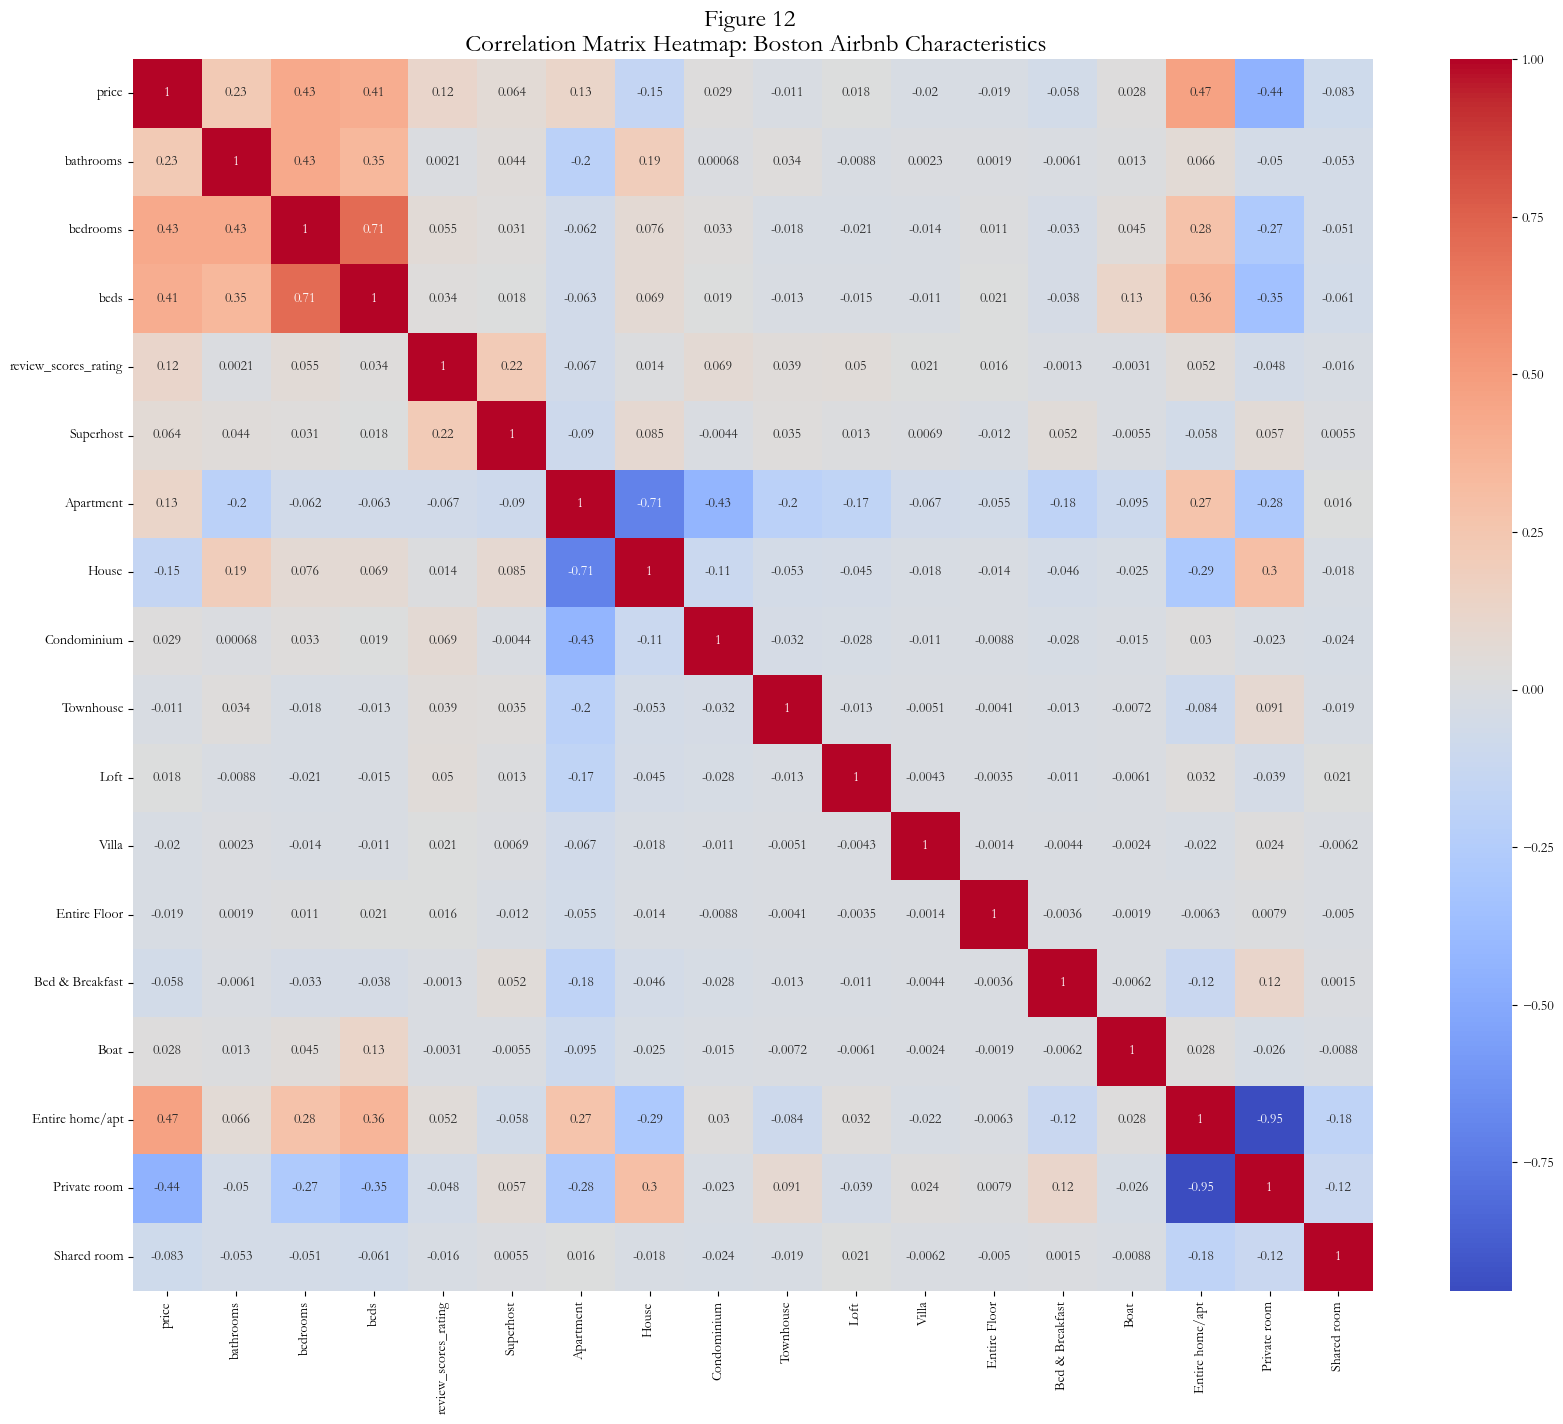

In [1918]:
#Exclude "Camper/RV" as not enough data points to be meaningful
#Exclude "Other" property type
#Guesthouse and Dorm are also dropped as they have very few data points
corr = CalLisCrime.drop_duplicates(subset=['id'])[["price", "bathrooms", "bedrooms", "beds", 
                  "review_scores_rating", "Superhost", "Apartment", 
                  "House", "Condominium", "Townhouse", 
                  "Loft", "Villa", "Entire Floor", 
                  "Bed & Breakfast", "Boat", 
                  "Entire home/apt", "Private room", "Shared room"]].corr()

#Configure figure and axes
fig, ax = plt.subplots(figsize=(20, 16))

#Create heatmap
sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax)

#Create title
ax.set_title("Figure 12 \n Correlation Matrix Heatmap: Boston Airbnb Characteristics", fontsize=18)

plt.show()

Before conducting my difference in differences regression analysis, I first create a correlation matrix heatmap of Boston Airbnb characteristics. This is presented above in Figure 12. This matrix is necessary to determine which variables in my dataset are potential confounders that will bias my regression estimates. This likely occurs if a variable is correlated with price.

This matrix shows that the variables which are most likely to be confounders include room type, the number of beds, and the number of bedrooms due to their high correlation with price relative to the other variables. However, I will still include property type and the number of bedrooms in my regression as, intuitively, it makes sense that these variables are determinants of price.

Importantly, the number of beds is highly correlated with the number of bedrooms. Thus, to reduce the likelihood of multicollinearity, I will use a proxy variable called beds per bedroom in lieu of these two confounders.

## 7.2. Checking the Parallel Trends Assumption

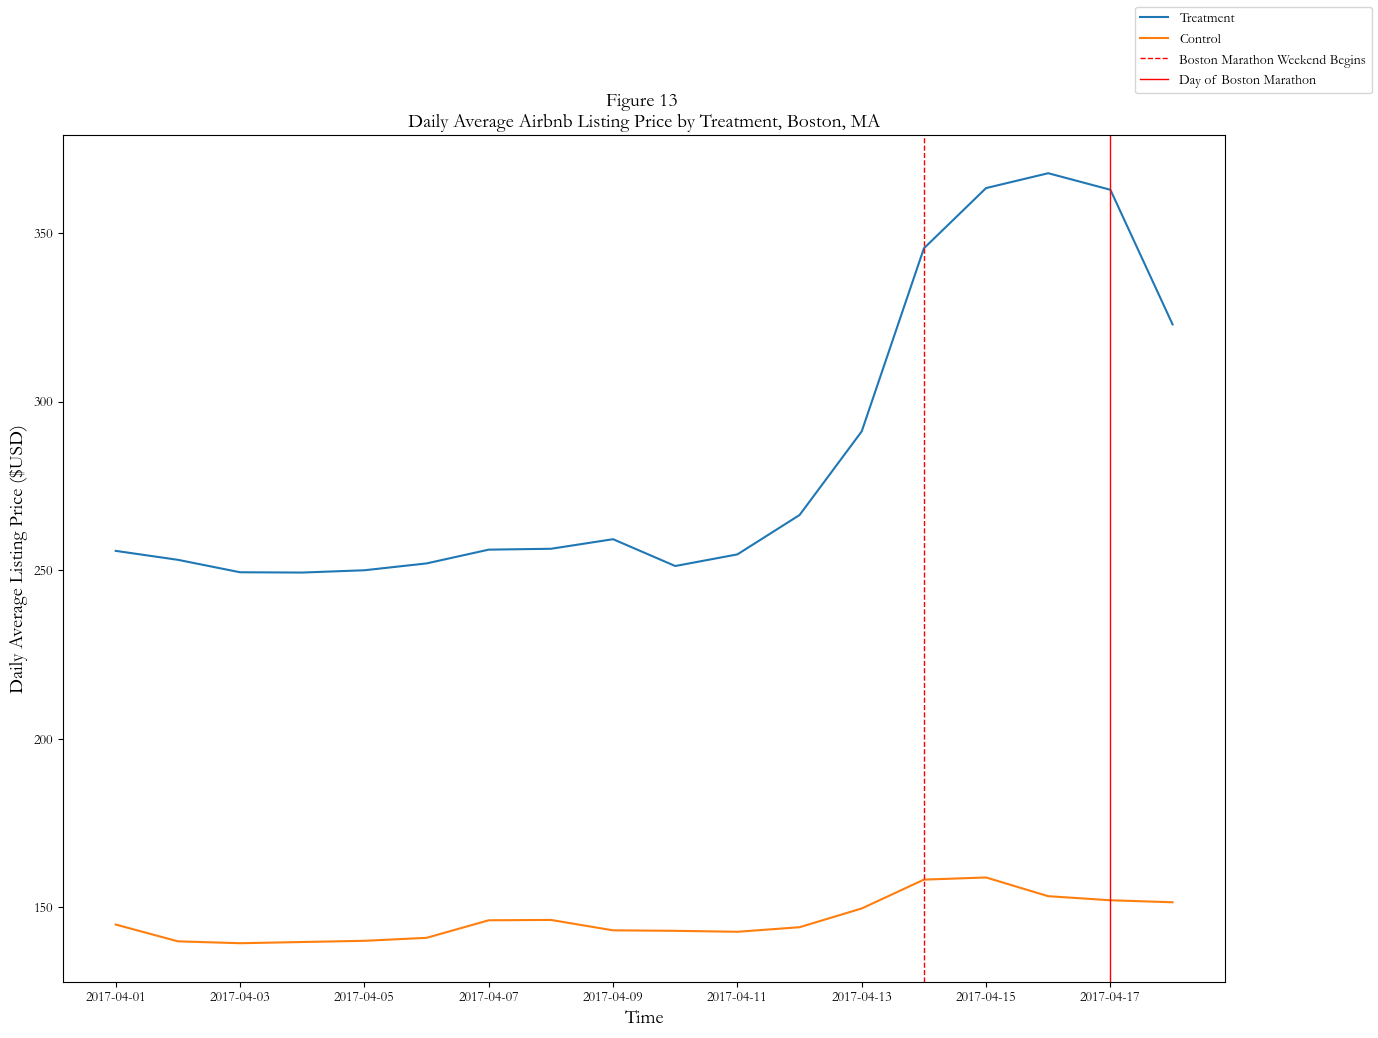

In [1919]:
treatment = ["Back Bay", "Beacon Hill", "Fenway", "Downtown", "South End",
         "Chinatown", "North End", "West End", "Leather District", "Bay Village"]
control = ["Allston", "Mission Hill", "Charlestown", "Brighton", "East Boston", 
           "Hyde Park", "Jamaica Plain", "Roslindale", "Dorchester", "West Roxbury", 
           "Mattapan", "South Boston Waterfront", "South Boston", "Longwood Medical Area", 
           "Roxbury"]

#Create a new column for beds per bedroom. If a listing has 0 bedrooms, set beds per bedroom to NaN
CalLisCrime["Beds per Bedroom"] = np.where(CalLisCrime["bedrooms"] == 0, \
      np.nan, CalLisCrime["beds"] / CalLisCrime["bedrooms"])

#Create dummy variables indicating if a listing is in a treatment or control neighbourhood
CalLisCrime["treatment"] = CalLisCrime["neighbourhood_cleansed"].isin(treatment).astype(int)
CalLisCrime["control"] = CalLisCrime["neighbourhood_cleansed"].isin(control).astype(int)

trends_frame = CalLisCrime.groupby(["treatment", "date"])["price"].mean().to_frame().reset_index()

trends_frame = trends_frame[(trends_frame["date"] >= "2017-04-01") & (trends_frame["date"] <= "2017-04-18")]

trends_frame_graph = trends_frame.groupby("treatment")

# Configure figure and axes
fig, ax = plt.subplots(figsize=(15, 11))

# Plot separate lines for treatment = 1 and treatment = 0
ax.plot(trends_frame_graph.get_group(1)["date"], trends_frame_graph.get_group(1)["price"], label="Treatment")
ax.plot(trends_frame_graph.get_group(0)["date"], trends_frame_graph.get_group(0)["price"], label="Control")

ax.set_title("Figure 13 \n"
"Daily Average Airbnb Listing Price by Treatment, Boston, MA", 
fontsize=14)

ax.set_xlabel("Time", fontsize = 14)
ax.set_ylabel("Daily Average Listing Price ($USD)", fontsize = 14)

#Place 2 vertical lines for August 14th and August 17th
ax.axvline(x=pd.to_datetime("2017-04-14"), color="red", linestyle="--", linewidth=1, 
           label="Boston Marathon Weekend Begins")
ax.axvline(x=pd.to_datetime("2017-04-17"), color="red", linestyle="-", linewidth=1,
              label="Day of Boston Marathon")

#Place legend in upper right corner
fig.legend(loc="upper right")

plt.show()



Figure 13 plots the daily average listing price for my treatment and control groups for April 1st to April 18th, 2017. This figure is constructed to visually inspect if the parallel trends assumption holds.

Note that my treatment group includes Airbnb listings from: Back Bay, Beacon Hill, Fenway, Downtown, South End, Chinatown, North End, West End, Leather District, and Bay Village. These are neighbourhoods classified as 'close' to the Boston Marathon finish line.

From this, my control group includes Airbnb listings from: Allston, Mission Hill, Charlestown, Brighton, East Boston, Hyde Park, Jamaica Plain, Roslindale, Dorchester, West Roxbury, Mattapan, South Boston Waterfront, South Boston, Longwood Medical Area, and Roxbury. These are neighbourhoods classified as either 'mid range' or 'far'.

Difference-in-differences analysis rests on the assumption of common trends. For my context, this means that in the absence of the Boston Marathon, the treatment and control group's listing prices should follow along a similar trend (Angrist & Pischke, 2015). However, this assumption does not appear to firmly hold for the pre marathon period after visually inspecting Figure 13. Thus, the control variables noted above will be used to assume parallel trends conditional on controls, and to remove selection bias between my treatment and control groups (Fredriksson & Oliveira, 2019). 

## 7.3. Pre-Treatment Balance Between Treatment and Control Listings

In [1920]:
treatment = ["Back Bay", "Beacon Hill", "Fenway", "Downtown", "South End",
         "Chinatown", "North End", "West End", "Leather District", "Bay Village"]
control = ["Allston", "Mission Hill", "Charlestown", "Brighton", "East Boston", 
           "Hyde Park", "Jamaica Plain", "Roslindale", "Dorchester", "West Roxbury", 
           "Mattapan", "South Boston Waterfront", "South Boston", "Longwood Medical Area", 
           "Roxbury"]

#Create a new column for beds per bedroom. If a listing has 0 bedrooms, set beds per bedroom to NaN
CalLisCrime["Beds per Bedroom"] = np.where(CalLisCrime["bedrooms"] == 0, \
      np.nan, CalLisCrime["beds"] / CalLisCrime["bedrooms"])

#Create dummy variables indicating if a listing is in a treatment or control neighbourhood
CalLisCrime["treatment"] = CalLisCrime["neighbourhood_cleansed"].isin(treatment).astype(int)
CalLisCrime["control"] = CalLisCrime["neighbourhood_cleansed"].isin(control).astype(int)

balance_frame = CalLisCrime.copy()

#Create a dataframe with only the columns needed for the balance test
balance_frame = balance_frame[["date", "bathrooms", "bedrooms", "beds",
                              "Superhost", "Entire home/apt", "control",
                              "Private room", "Shared room", 
                              "treatment", "Beds per Bedroom", "price"]]

#Restrict dataset to April 10th, 2017
balance_frame = balance_frame[balance_frame["date"] == "2017-04-10"]

count = balance_frame[["treatment", "control"]].sum().to_frame().T
count["Total"] = count["treatment"] + count["control"]
count.columns = ["Treatment", "Control", "Difference"]

#Calculate the mean of each column for treatment and control
balance_frame = balance_frame.groupby("treatment")[["price", "bathrooms", "bedrooms",
                                    "beds", "Beds per Bedroom", "Superhost",
                                    "Entire home/apt", "Private room", 
                                    "Shared room"]].mean().T.reset_index()

#Calculate the difference between treatment and control
balance_frame["difference"] = balance_frame[1] - balance_frame[0]

#Rename columns
balance_frame.columns = ["Variable", "Treatment", "Control", "Difference"]

#Set index to "Variable"
balance_frame.set_index("Variable", inplace=True)

#Put count row at the top
balance_frame = pd.concat([balance_frame, count])

#Rename all rows
balance_frame.index = ["Price", "Bathrooms", "Bedrooms", "Beds", "Beds per Bedroom",
                       "Superhost", "Entire home/apt", "Private room", "Shared room",
                       "N"]

#Create title and round numbers to 3 decimal places
balance_frame.style.set_caption("Table 5: Balance Test for Treatment and Control \
                  Neighbourhoods - Boston, MA: April 10th, 2017").format("{:.3f}")


,Treatment,Control,Difference
Price,143.070,251.245,108.174
Bathrooms,1.245,1.192,-0.052
Bedrooms,1.319,1.175,-0.144
Beds,1.637,1.573,-0.065
Beds per Bedroom,1.208,1.227,0.019
Superhost,0.131,0.091,-0.041
Entire home/apt,0.428,0.804,0.376
Private room,0.547,0.177,-0.370
Shared room,0.025,0.019,-0.006
N,1577.000,2009.000,3586.000


Table 5 presents the means of relevant observable variables by treatment and control group. This table is intended to check for balance between my treatment and control groups, as imbalance yields section bias in my regression estimates (Angrist & Pischke, 2015). Evidently, there is imbalance in my variables, meaning they will need to be added as controls in my regression.

## 7.4. Two-Period Difference-in-Differences Regression

I first estimate a simple two period difference-in-differences regression model akin to Angrist & Pischke (2015):

$$
\log(\text{Price}_{it}) = \beta_0 + \beta_1 \text{Treatment}_{i} + \beta_2 \text{MarathonDate}_{t} + \beta_3 \text{Superhost}_{i} \\
+ \beta_4 (\text{Treatment}_{i} \times \text{MarathonDate}_{t}) + \beta_5 (\text{Treatment}_{i} \times \text{MarathonDate}_{t} \times \text{Superhost}_{i}) + \beta_6 X_{it}' + \varepsilon_{it}
$$

Where:
- $ \log(\text{Price}_{it}) $ is the log of Airbnb listing price for listing $i$ on date $t$.
- $ \text{Treatment}_{i} $ is an indicator that equals 1 if listing $i$ is in the treatment group, and 0 if listing $i$ is in the control group.
- $ \text{MarathonDate}_{t} $ is an indicator that equals 1 if day $t$ is April 17, 2017 (Boston Marathon date), and 0 if day $t$ is April 10th, 2017.
- $ \text{Superhost}_{i} $ is an indicator that equals 1 if listing $i$ is a Superhost, and 0 otherwise.
- $ \text{Treatment}_{i} \times \text{MarathonDate}_{t} $ is an interaction term that captures the causal effect of the marathon on listing price.
- $ \text{Treatment}_{i} \times \text{MarathonDate}_{t} \times \text{Superhost}_{i} $ is a triple interaction term that allows for heterogeneous effects of the marathon on Superhost listings.
- $ X_{it}' $ is a vector of additional control variables for listing $i$ on date $t$.
- $ \varepsilon_{it} $ is the error term.

In [ ]:
reg_frame1 = CalLisCrime.copy()

#Drop NaN id values
reg_frame1.dropna(subset=["id"], inplace=True)

#Filter to include only listings with a price
reg_frame1 = CalLisCrime[CalLisCrime["price"].notna()]

#Filter to only inlude April 10th to 17th, 2017
reg_frame1 = reg_frame1[(reg_frame1["date"] == "2017-04-10") | \
                        (reg_frame1["date"] == "2017-04-17")]

#Drop listings with Nan in Beds per Bedroom or bathrooms
reg_frame1 = reg_frame1[reg_frame1["bathrooms"].notna()]
reg_frame1 = reg_frame1[reg_frame1["Beds per Bedroom"].notna()]

#Create a dummy if listing is on the day of the Boston Marathon
reg_frame1["Marathon Period"] = (reg_frame1["date"] == "2017-04-17").astype(int)

#Create log price variable
reg_frame1["Log(Price)"] = np.log(reg_frame1["price"])

#Create interaction term between treatment and marathon date
reg_frame1["Treatment*Marathon Period"] = reg_frame1["treatment"] * \
                                       reg_frame1["Marathon Period"]

#Create a triple interaction with treatment, marathon date, and superhost
reg_frame1["Treatment*Marathon Period*Superhost"] = reg_frame1["treatment"]* \
    reg_frame1["Marathon Period"] * reg_frame1["Superhost"]


In [1922]:
Y = reg_frame1["Log(Price)"]

X1 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period"]]
X1 = sm.add_constant(X1)

X2 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", "Superhost"]]
X2 = sm.add_constant(X2)

X3 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", 
                "Superhost", "Treatment*Marathon Period*Superhost"]]
X3 = sm.add_constant(X3)

X4 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", 
                "Superhost", "Treatment*Marathon Period*Superhost", "Beds per Bedroom"]]
X4 = sm.add_constant(X4)

X5 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period", 
                "Superhost", "Treatment*Marathon Period*Superhost", 
                "Beds per Bedroom", "bathrooms"]]
X5 = sm.add_constant(X5)

X6 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period",
                "Superhost", "Treatment*Marathon Period*Superhost", 
                "Beds per Bedroom", "bathrooms", "crime_count"]]
X6 = sm.add_constant(X6)

#Entire home/apt is reference
X7 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period",
                "Superhost", "Treatment*Marathon Period*Superhost", 
                "Beds per Bedroom", "bathrooms", "crime_count",
                "Private room", "Shared room"]]
X7 = sm.add_constant(X7)

#Home is reference
#Drop Villa due to there only being 2 observations
X8 = reg_frame1[["treatment", "Marathon Period", "Treatment*Marathon Period",
                "Superhost", "Treatment*Marathon Period*Superhost", 
                "Beds per Bedroom", "bathrooms", "crime_count",
                "Private room", "Shared room", 'Apartment', 'Bed & Breakfast', 
                'Boat', 
                'Condominium', 'Entire Floor', 
                'Loft', 'Townhouse']]
X8 = sm.add_constant(X8)

#Cluster se's at the listing level
model1 = sm.OLS(Y, X1).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model2 = sm.OLS(Y, X2).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model3 = sm.OLS(Y, X3).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model4 = sm.OLS(Y, X4).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model5 = sm.OLS(Y, X5).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model6 = sm.OLS(Y, X6).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model7 = sm.OLS(Y, X7).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})
model8 = sm.OLS(Y, X8).fit(cov_type="cluster", cov_kwds={"groups": reg_frame1["id"]})

stargazer = Stargazer([model1, model2, model3, model4, model5, model6, model7, model8])

stargazer.covariate_order(["treatment", "Marathon Period",
                            "Treatment*Marathon Period",
                            "Superhost",
                            "Treatment*Marathon Period*Superhost",
                            "Beds per Bedroom", "bathrooms", "crime_count",
                            "const"])

#Rename regressors for table
stargazer.rename_covariates({
    "treatment": "Treatment Listing",
    "Marathon Period": "Boston Marathon Day",
    "Treatment*Marathon Period": "Treatment Listing X Boston Marathon Day",
    "Treatment*Marathon Period*Superhost": "Treatment Listing X Marathon Day X Superhost",
    "bathrooms": "Number of Bathrooms",
    "crime_count": "Number of Crimes",
    "const": "Constant"
})

stargazer.add_line("Room Type Controls", 
                   ["No", "No", "No", "No", "No", "No", "Yes", "Yes"])
stargazer.add_line("Property Type Controls", 
                   ["No", "No", "No", "No", "No", "No", "No", "Yes"])

#Create a title
stargazer.title("Table 6: Two Period Difference-in-Differences Regression Estimates")

#Create a note
stargazer.add_custom_notes(["Standard errors are clustered at the listing level. \
                            The dependent variable is the natural log of listing price. The sample \
                            includes listings with observations on April 10th and 17th, 2017. \
                            Listings are assigned to treatment based on their neighbourhood. \
                            Treatment neighbourhoods include: Back Bay, Beacon Hill, Fenway, "
                            "Downtown, South End, Chinatown, North End, West End,"
                            " Leather District, and Bay Village. "
                            "These are neighbourhoods classified as 'close' to the "
                            "Boston Marathon finish line. Control neighbourhoods include: "
                            "Allston, Mission Hill, Charlestown, Brighton, East Boston, "
                            "Hyde Park, Jamaica Plain, Roslindale, Dorchester, West Roxbury, "
                            "Mattapan, South Boston Waterfront, South Boston, Longwood Medical "
                            "Area, and Roxbury. These are neighbourhoods classified as either 'mid range' "
                            "or 'far'."])
                           

html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output))

My preferred regression is specification 8.

The coefficient on Treatment Listing X Boston Marathon Period indicates that, after controlling for property type, room type, the daily number of crimes, the number of bathrooms, the number of beds per bedroom, and Superhost status, Airbnb listings in the treatment group had approximately 18.3% higher listing prices on the day of the Boston Marathon relative to listings in the control group. This implies a significant price surge in areas close to the marathon finish line, which is consistent with my hypothesis that increased demand during the event led to higher listing prices. Furthermore, this coefficient is statistically significant at the 1% level.

Furthermore, the coefficient on Treatment Listing X Marathon Period X Superhost indicates that, after controlling for the variables listed above, Superhost listings in the treatment group had prices that were approximately 39% higher on the day of the Boston Marathon compared to non-Superhost listings in the control group. This suggests that Superhost differ in their 'marathon pricing strategy'. This coefficient is also statistically significant at the 1% level.

## 7.4.1. Placebo Test

In [1923]:
reg_frame2 = CalLisCrime.copy()

#Drop NaN id values
reg_frame2.dropna(subset=["id"], inplace=True)

#Filter to include only listings with a price
reg_frame2 = CalLisCrime[CalLisCrime["price"].notna()]

#Filter to only inlude April 3rd and April 10th
reg_frame2 = reg_frame2[(reg_frame2["date"] == "2017-04-03") | \
                         (reg_frame2["date"] == "2017-04-10")]

#Drop listings with Nan in Beds per Bedroom or bathrooms
reg_frame2 = reg_frame2[reg_frame2["bathrooms"].notna()]
reg_frame2 = reg_frame2[reg_frame2["Beds per Bedroom"].notna()]

#Create a dummy if listing is on placebo period
reg_frame2["Placebo Period"] = (reg_frame2["date"] == "2017-04-10").astype(int)

#Create log price variable
reg_frame2["Log(Price)"] = np.log(reg_frame2["price"])

#Create interaction term between treatment and marathon date
reg_frame2["Treatment*Placebo Period"] = reg_frame2["treatment"] * \
                                       reg_frame2["Placebo Period"]

reg_frame2["Treatment*Placebo Period*Superhost"] = reg_frame2["treatment"]* \
    reg_frame2["Placebo Period"] * reg_frame2["Superhost"]


In [1924]:
Y = reg_frame2["Log(Price)"]

X1 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period"]]
X1 = sm.add_constant(X1)

X2 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period", "Superhost"]]
X2 = sm.add_constant(X2)

X3 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period", 
                "Superhost", "Beds per Bedroom"]]
X3 = sm.add_constant(X3)

X4 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period", 
                "Superhost", 
                "Beds per Bedroom", "bathrooms"]]
X4 = sm.add_constant(X4)

X5 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period",
                "Superhost", 
                "Beds per Bedroom", "bathrooms", "crime_count"]]
X5 = sm.add_constant(X5)

#Entire home/apt is reference
X6 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period",
                "Superhost", 
                "Beds per Bedroom", "bathrooms", "crime_count",
                "Private room", "Shared room"]]
X6 = sm.add_constant(X6)

#Home is reference
#Drop Villa due to there only being 2 observations
X7 = reg_frame2[["treatment", "Placebo Period", "Treatment*Placebo Period",
                "Superhost", 
                "Beds per Bedroom", "bathrooms", "crime_count",
                "Private room", "Shared room", 'Apartment', 'Bed & Breakfast', 
                'Boat', 
                'Condominium', 'Entire Floor', 
                'Loft', 'Townhouse']]
X7 = sm.add_constant(X7)

model1 = sm.OLS(Y, X1).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model2 = sm.OLS(Y, X2).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model3 = sm.OLS(Y, X3).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model4 = sm.OLS(Y, X4).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model5 = sm.OLS(Y, X5).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model6 = sm.OLS(Y, X6).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})
model7 = sm.OLS(Y, X7).fit(cov_type="cluster", cov_kwds={"groups": reg_frame2["id"]})

stargazer = Stargazer([model1, model2, model3, model4, model5, model6, model7])

stargazer.add_line("Room Type Controls", 
                   ["No", "No", "No", "No", "No", "Yes", "Yes"])
stargazer.add_line("Property Type Controls", 
                   ["No", "No", "No", "No", "No", "No", "Yes"])

stargazer.covariate_order(["treatment", "Placebo Period",
                            "Treatment*Placebo Period",
                            "Superhost",
                            "Beds per Bedroom", "bathrooms", 
                            "crime_count",
                            "const"])

#Rename regressors for table
stargazer.rename_covariates({
    "treatment": "Treatment Listing",
    "Placebo Period": "Placebo Period",
    "Treatment*Placebo Period": "Treatment Listing X Placebo Period",
    "bathrooms": "Number of Bathrooms",
    "crime_count": "Number of Crimes",
    "const": "Constant"
})

#Create a title
stargazer.title("Table 7: Two Period Difference-in-Differences Placebo Regression Estimates")

#Create a note
stargazer.add_custom_notes(["Standard errors are clustered at the listing level. \
                            The dependent variable is the natural log of listing price. The sample \
                            includes listings with observations on April 3rd and 10th, 2017. \
                            April 10th is the placebo period. \
                            Listings are assigned to treatment based on their neighbourhood. \
                            Treatment neighbourhoods include: Back Bay, Beacon Hill, Fenway, "
                            "Downtown, South End, Chinatown, North End, West End,"
                            " Leather District, and Bay Village. "
                            "These are neighbourhoods classified as 'close' to the "
                            "Boston Marathon finish line. Control neighbourhoods include: "
                            "Allston, Mission Hill, Charlestown, Brighton, East Boston, "
                            "Hyde Park, Jamaica Plain, Roslindale, Dorchester, West Roxbury, "
                            "Mattapan, South Boston Waterfront, South Boston, Longwood Medical "
                            "Area, and Roxbury. These are neighbourhoods classified as either 'mid range' "
                            "or 'far'."])
                           

html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output))

My preferred regression is specification 7.

One test for the validity of a difference-in-differences regression is a placebo test (Cunningham, 2021).

Under my two period difference-in-differences placebo estimates, which includes the days April 3rd, 2017, and April 10th, 2017, we can see that the coefficient on Treatment Listing X Placebo Period is no longer statistically significant. This therefore indicates that there was no significant difference in price trends between the treatment and control groups during this period before the Boston Marathon. These finds ultimately strengthen a causal interpretation of the 2 period regression results, and also supports the parallel trends assumption holding.

## 7.5. Difference-in-Differences Regression with Panel Fixed Effects

Lastly, I estimate a difference-in-differences regression model with panel fixed effects akin to Angrist and Pischke (2015). This model also relaxes the common trends assumption:

$$
\log(\text{Price}_{it}) = \beta_0 + \beta_1 (\text{Treatment}_i \times \text{MarathonPeriod}_t) + \\ + \beta_2 (\text{Treatment}_i \times \text{MarathonPeriod}_t \times Superhost_i)  
 + \beta_3 (\text{Treatment}_i \times t)  \\
+ \sum_{t} \beta_{4t} DailyFE_t + \sum_{i} \beta_{5i} ListingFE_i + \varepsilon_{it}
$$

### **Where:**
- $ \log(\text{Price}_{it}) $ is the log of Airbnb listing price for listing $i$ on date $t$.
- $ \text{Treatment}_{i} $ is an indicator that equals 1 if listing $i$ is in the treatment group, and 0 if listing $i$ is in the control group.
- $ \text{MarathonPeriod}_{t} $ is an indicator that equals 1 if day $t$ is between April 14th and 17th, 2017 inclusive, and 0 if day $t$ is between April 10th and 13th, 2017 inclusive.
- $ \text{Treatment}_{i} \times \text{MarathonPeriod}_{t} $ is an interaction term that captures the causal effect of the marathon on listing price.
- $ \text{Superhost}_{i} $ is an indicator that equals 1 if listing $i$ is a Superhost, and 0 otherwise.
- $ \text{Treatment}_{i} \times \text{MarathonPeriod}_{t} \times \text{Superhost}_{i} $ is a triple interaction term that allows for heterogeneous effects of the marathon on Superhost listings.
- $ \text{Treatment}_{i} \times t $ is an interaction term that allows for different pre-treatment trends between treatment and control groups, relaxing the parallel trends assumption.
- **$ \sum_t \beta_{5t} DailyFE_t $** are Daily Fixed Effects which control for shocks affecting all listings on the same day.  
- **$ \sum_i \beta_{6i} ListingFE_i $** are Listing Fixed Effects which control for listing characteristics that do not change over time.  
- **$ \varepsilon_{it} $** is the error term. 

In [1925]:
#Documentation: 
#https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html
from linearmodels.panel import PanelOLS

panel_frame = CalLisCrime.copy()

#Filter to include only August 10th to 17th
panel_frame = panel_frame[(panel_frame["date"] >= "2017-04-10") & 
                          (panel_frame["date"] <= "2017-04-17")]

#Create dummy if listing falls in marathon period
#Marathon period falls between August 14th to 17th
panel_frame["MarathonPeriod"] = (panel_frame["date"] >= "2017-04-14").astype(int)

#Create log price variable
panel_frame["Log_Price"] = np.log(panel_frame["price"])

#Create interaction term between treatment and marathon date
panel_frame["Treatment_MarathonPeriod"] = panel_frame["treatment"] * \
                                       panel_frame["MarathonPeriod"]

#Create triple interaction term between treatment, marathon date, and superhost
panel_frame["Treatment_MarathonPeriod_Superhost"] = panel_frame["treatment"] * \
    panel_frame["MarathonPeriod"] * panel_frame["Superhost"]

#Create a time variable which indicates the number of days since the first date
panel_frame["time"] = (panel_frame["date"] - panel_frame["date"].min()).dt.days

#Create an interaction between time and treatment
#Allows for non parallel pre-trends
panel_frame["treatment_time"] = panel_frame["treatment"] * panel_frame["time"]

#Keep id as a column for clustering
panel_frame["id_col"] = panel_frame["id"]  

# Set index to id and date for PanelOLS model
panel_frame = panel_frame.set_index(['id', 'date'])

#Drop NaN values in Log_Price and Treatment_MarathonPeriod
panel_frame = panel_frame.dropna(subset=["Log_Price", "Treatment_MarathonPeriod"])

#Run PanelOLS model from a formula
#Entity Effects and Time Effects are defined by the index
#Entity Effects correspond to the id variable
#Time Effects correspond to the date variable
model1 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + EntityEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])  

model2 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + TimeEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

model3 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + EntityEffects + TimeEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

model4 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + Treatment_MarathonPeriod_Superhost + EntityEffects + TimeEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

model5 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_MarathonPeriod + Treatment_MarathonPeriod_Superhost + treatment_time + EntityEffects + TimeEffects",
    data=panel_frame
).fit(cov_type="clustered", clusters=panel_frame["id_col"])

#Create table for model

stargazer = Stargazer([model1, model2, model3, model4, model5])

#Add row to table to indicate which effects are active in each column
stargazer.add_line("Listing Fixed Effects", 
                   ["Yes", "No", "Yes", "Yes", "Yes"])
stargazer.add_line("Daily Fixed Effects", 
                   ["No", "Yes", "Yes", "Yes", "Yes"])

#Reorder rows
stargazer.covariate_order(["Treatment_MarathonPeriod",
                            "Treatment_MarathonPeriod_Superhost",
                            "treatment_time"])

#Rename interaction term
stargazer.rename_covariates({"Treatment_MarathonPeriod": "Treatment Listing X Marathon Period",
                             "Treatment_MarathonPeriod_Superhost": 
                             "Treatment Listing X Marathon Period X Superhost",
                             "treatment_time": "Treatment Listing X Time",
                            })

#Create a title
stargazer.title("Table 8: Panel Difference-in-Differences Regression Estimates")

#Create a note
stargazer.add_custom_notes(["Standard errors are clustered at the listing level. \
                            The dependent variable is the natural log of listing price. The sample \
                            includes listings with observations on April 10th and 17th, 2017. \
                            Listings are assigned to treatment based on their neighbourhood. \
                            Treatment neighbourhoods include: Back Bay, Beacon Hill, Fenway, "
                            "Downtown, South End, Chinatown, North End, West End,"
                            " Leather District, and Bay Village. "
                            "These are neighbourhoods classified as 'close' to the "
                            "Boston Marathon finish line. Control neighbourhoods include: "
                            "Allston, Mission Hill, Charlestown, Brighton, East Boston, "
                            "Hyde Park, Jamaica Plain, Roslindale, Dorchester, West Roxbury, "
                            "Mattapan, South Boston Waterfront, South Boston, Longwood Medical "
                            "Area, and Roxbury. These are neighbourhoods classified as either 'mid range' "
                            "or 'far'."])
                           
html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output))

My preferred regression is specification 5.

Note, the superhost dummy is captured by the fixed effects and is thus not included in the model. Also, the Time variable on the Treatment Listing X Time interaction was constructed by subtracting each date by the lowest date in my dataset (that being April 10th, 2017).

The coefficient on Treatment Listing X Marathon Period indicates that after controlling for listing and daily fixed effects, Airbnb listings in the treatment group had approximately 5.4% higher listing prices on the day of the Boston Marathon relative to listings in the control group. This coefficient is also statistically significant at the 1% level. This finding is consistent with my hypothesis that increased demand during the event led to higher listing prices.

Furthermore, the coefficient on Treatment Listing X Marathon Period X Superhost indicates that, after controlling listing and daily fixed effects, Superhost listings in the treatment group had prices that were approximately 8.9% higher on the day of the Boston Marathon compared to non-Superhost listings in the control group. This coefficient is also statistically significant at the 5% level. This supports claims that Superhosts vary in their 'marathon pricing strategy'. 

The coefficient on Treatment Listing X Time also suggests that the parallel trends assumption does not hold.

Lastly, the magnitude of these estimate is smaller than what is presented in table 6. This suggests that my two period DiD regressions provide overestimates.


## 7.5.1. Placebo Test

In [1926]:
panel_placebo = CalLisCrime.copy()

#Filter to include only August 3rd to 10th
panel_placebo = panel_placebo[(panel_placebo["date"] >= "2017-04-03") & 
                          (panel_placebo["date"] <= "2017-04-10")]

#Placebo period falls between August 7th to 10th
panel_placebo["PlaceboPeriod"] = (panel_placebo["date"] >= "2017-04-07").astype(int)

#Create log price variable
panel_placebo["Log_Price"] = np.log(panel_placebo["price"])

#Create interaction term between treatment and placebo period
panel_placebo["Treatment_PlaceboPeriod"] = panel_placebo["treatment"] * \
                                       panel_placebo["PlaceboPeriod"]

#Create a time variable which indicates the number of days since the first date
panel_placebo["time"] = (panel_placebo["date"] - panel_placebo["date"].min()).dt.days

#Create an interaction between time and treatment
panel_placebo["treatment_time"] = panel_placebo["treatment"] * panel_placebo["time"]

#Create a column for id for clustering
panel_placebo["id_col"] = panel_placebo["id"]

#Set index to id and date for PanelOLS model
panel_placebo = panel_placebo.set_index(['id', 'date'])

#Drop NaN values in Log_Price and Treatment_PlaceboPeriod
panel_placebo = panel_placebo.dropna(subset=["Log_Price", "Treatment_PlaceboPeriod"])

#Run PanelOLS model from a formula
#Entity Effects and Time Effects are defined by the index
#Entity Effects correspond to the id variable
#Time Effects correspond to the date variable
model1 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + EntityEffects",
    data=panel_placebo
).fit(cov_type="clustered", clusters=panel_placebo["id_col"])

model2 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + TimeEffects",
    data=panel_placebo
).fit(cov_type="clustered", clusters=panel_placebo["id_col"])

model3 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + EntityEffects + TimeEffects",
    data=panel_placebo
).fit(cov_type="clustered", clusters=panel_placebo["id_col"])

model4 = PanelOLS.from_formula(
    "Log_Price ~ Treatment_PlaceboPeriod + treatment_time + EntityEffects + TimeEffects",
    data=panel_placebo
).fit(cov_type="clustered", clusters=panel_placebo["id_col"])

#Create table for model
stargazer = Stargazer([model1, model2, model3, model4])

#Add row to table to indicate which effects are active in each column
stargazer.add_line("Listing Fixed Effects", 
                   ["Yes", "No", "Yes", "Yes"])
stargazer.add_line("Time Fixed Effects", 
                   ["No", "Yes", "Yes", "Yes"])

#Rename interaction term
stargazer.rename_covariates({"Treatment_PlaceboPeriod": "Treatment Listing X Placebo Period",
                             "treatment_time": "Treatment Listing X Time"})

#Create a title
stargazer.title("Table 9: Panel Difference-in-Differences Placebo Regression Estimates")

#Create a note
stargazer.add_custom_notes(["Standard errors are clustered at the listing level. \
                            The dependent variable is the natural log of listing price. The sample \
                            includes listings with observations on April 3rd and 10th, 2017. \
                            April 10th is the placebo period. \
                            Listings are assigned to treatment based on their neighbourhood. \
                            Treatment neighbourhoods include: Back Bay, Beacon Hill, Fenway, "
                            "Downtown, South End, Chinatown, North End, West End,"
                            " Leather District, and Bay Village. "
                            "These are neighbourhoods classified as 'close' to the "
                            "Boston Marathon finish line. Control neighbourhoods include: "
                            "Allston, Mission Hill, Charlestown, Brighton, East Boston, "
                            "Hyde Park, Jamaica Plain, Roslindale, Dorchester, West Roxbury, "
                            "Mattapan, South Boston Waterfront, South Boston, Longwood Medical "
                            "Area, and Roxbury. These are neighbourhoods classified as either 'mid range' "
                            "or 'far'."])
                           
html_output = stargazer.render_html()

from IPython.display import display, HTML
display(HTML(html_output)) 

My preferred regression is specification 4.

As above, we can see that the coefficient on Treatment Listing X Placebo Period is no longer statistically significant which indicates that there was no significant difference in price trends between the treatment and control groups during the placebo period before the Boston Marathon.

# 7. Conclusion

To conclude, the results of my project support there having been a ‘Boston Marathon effect’ on Airbnb listing prices. My results also suggest that Superhosts vary in their 'marathon pricing strategy' compared to non Superhosts. Importantly, the effect of the marathon appears to be isolated only to Airbnb’s that are ‘close’ to the Boston Marathon finish line. This then supports my research design which assigns listings into treatment and control groups based on their distance to said finish line. However, the results of my difference-in-differences regressions may not be causal as the parallel trends assumption does not hold. Still, my panel design relaxes this assumption. In the future, I plan to determine (by web-scraping data) if other short term rental platforms in Boston (ie. Booking.com, Vrbo) experienced a similar surge in prices during the Boston Marathon, and if not, what the implications of this are from a competition perspective.

# Bibliography

Analyze Boston & Boston Planning & Development Agency. (2018). *Demographic Data for Boston’s Neighborhoods, 1950-2019*. [Data Set]. https://data.boston.gov/dataset/neighborhood-demographics.

AnkurJain. (2019). *Crimes in Boston*. [Data Set]. https://www.kaggle.com/datasets/ankkur13/boston-crime-data.

Angrist, J. D., & Pischke, J.-S. (2015). *Mastering ’Metrics: The Path From Cause to Effect*. Princeton University Press.

Boston Athletic Association Communications Department. (2017, March 23). *2017 Boston Marathon Will Mean $192.2 Million For Greater Boston Economy*. Boston Athletic Association. https://www.baa.org/2017-boston-marathon-will-mean-1922-million-greater-boston-economy.

Brady, J. (2017, April 17). *Boston Marathon 2017: Route information, course map, road closures and more*. SB Nation. https://www.sbnation.com/2017/4/17/15284838/2017-boston-marathon-route-map-traffic.

Cachon, G. P., Daniels, K. M., & Lobel, R. (2017). The Role of Surge Pricing on a Service Platform with Self-Scheduling Capacity. *Manufacturing & Service Operations Management*, 19(3), 368–384. https://doi.org/10.1287/msom.2017.0618.

Cheung, K. S., & Yiu, C. Y. (2023). The paradox of airbnb, crime and house prices: A reconciliation. *Tourism Economics: The Business and Finance of Tourism and Recreation*, 29(5), 1412–1418. https://doi.org/10.1177/13548166221102808.

City of Boston. (2009). *Neighbourhoods*. City of Boston. https://www.cityofboston.gov/images_documents/Neighborhoods_tcm3-8205.pdf. 

Cunningham, S. (2021). *Causal Inference: The Mixtape*. Yale University Press.

Ert, E., & Fleischer, A. (2019). The evolution of trust in Airbnb: A case of home rental. *Annals of Tourism Research*, 75, 279–287. https://doi.org/10.1016/j.annals.2019.01.004.

Fredriksson, A., & Oliveira, G. M. de. (2019). Impact evaluation using Difference-in-Differences. *RAUSP Management Journal*, 54(4), 519–532. https://doi.org/10.1108/RAUSP-05-2019-0112.

Jiao, J. (2018). Investigating Uber price surges during a special event in Austin, TX. *Research in Transportation Business & Management*, 29, 101–107. https://doi.org/10.1016/j.rtbm.2018.02.008.

Lawani, A., Reed, M. R., Mark, T., & Zheng, Y. (2019). Reviews and price on online platforms: Evidence from sentiment analysis of Airbnb reviews in Boston. *Regional Science and Urban Economics*, 75, 22–34. https://doi.org/10.1016/j.regsciurbeco.2018.11.003.

Leoni, V., & Nilsson, W. (2021). Dynamic pricing and revenues of Airbnb listings: Estimating heterogeneous causal effects. *International Journal of Hospitality Management*, 95, 102914-. https://doi.org/10.1016/j.ijhm.2021.102914.

Piga, C., & Melis, G. (2021). Identifying and measuring the impact of cultural events on hotels’ performance. *International Journal of Contemporary Hospitality Management*, 33(4), 1194–1209. https://doi.org/10.1108/IJCHM-07-2020-0749.

Wolak, A., & Airbnb. (2020). *Boston Airbnb Open Data*. [Data Set]. https://www.kaggle.com/datasets/airbnb/boston. 